# Deep learning techniques to identify the composer of a music piece

**Objective**  
The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

**Dataset**  
The project will use a dataset consisting of musical scores from various composers. The dataset contain MIDI files and sheet music of compositions from well-known classical composers like Bach, Beethoven, Chopin, Mozart, Schubert, etc. The dataset should be labeled with the name of the composer for each score.

## Data Collection

### Install required libraries

In [1]:
import sys

# Check if running in Google Colab
if 'google.colab' in sys.modules:
    print("Running on Colab: Installing fluidsynth and dependencies...")

    # Install correct pyfluidsynth
    !pip install pyfluidsynth

    # Install system fluidsynth and download a SoundFont
    !apt-get update -qq
    !apt-get install -y fluidsynth

    # Download a default SoundFont
    !wget -q -O /usr/share/sounds/sf2/FluidR3_GM.sf2 https://github.com/urish/candymidi/raw/master/assets/FluidR3_GM.sf2
else:
    print("Not running on Colab. Skipping system package installation.")


Running on Colab: Installing fluidsynth and dependencies...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-sou

In [3]:
# Import all dependent libraries
import os
import csv
import zipfile
import shutil

from pathlib import Path
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
import keras.optimizers
import tensorflow as tf

# Music related libraries
import music21
from music21 import converter, instrument, note, chord, tempo
try:
    import pretty_midi
except ImportError:
    !pip install pretty_midi
    import pretty_midi
import librosa
import librosa.display
try:
    import fluidsynth
except ImportError:
    !pip install pyfluidsynth
    import fluidsynth

import soundfile as sf

from tqdm import tqdm
from collections import Counter

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# Deep Learning Libraries
from keras.models import Sequential,load_model
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Activation
from keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from keras.utils import pad_sequences # not used , should we remove it?
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D,
                                     Dense, InputLayer)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from collections import Counter

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [1]:
# Function to check if running from colab
def is_running_on_colab():
  return 'google.colab' in str(get_ipython())

if is_running_on_colab():
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive' , force_remount=True)
  root_path = '/content/drive/MyDrive/AAI-511-IN2 Neural Networks and Deep Learning/Project'
else:
  print('Not running on Colab')
  root_path = '.'

Running on Colab
Mounted at /content/drive


In [4]:
# File path in Google Drive
file_path = os.path.join(root_path, 'Composer_Dataset.zip')

# Extract file path
# Check if Kaggle dataset already exists
extract_path = os.path.join(root_path, 'Kaggle_Composer_Dataset')

if not os.path.exists(extract_path):
    extract_path = os.path.join(root_path, 'Composer_Dataset')

print(f"Using dataset: {extract_path}")

# Dataset folders
path = Path(extract_path)
if "Kaggle_Composer_Dataset" in path.name:
    dataset_path = extract_path
else:
    dataset_path = os.path.join(extract_path, 'Composer_Dataset/NN_midi_files_extended')
print(f"Using extracted dataset: {dataset_path}")

# CSV index file
csv_file = os.path.join(dataset_path, 'composer_dataset_index.csv')

Using dataset: /content/drive/MyDrive/AAI-511-IN2 Neural Networks and Deep Learning/Project/Kaggle_Composer_Dataset
Using extracted dataset: /content/drive/MyDrive/AAI-511-IN2 Neural Networks and Deep Learning/Project/Kaggle_Composer_Dataset


In [ ]:
# Check if folder already exists
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [ ]:
# Function to clean the folders
def delete_hidden_folders(root_folder):
    for root, dirs, _ in os.walk(root_folder):
        for d in dirs:
            if d.startswith('.'):
                dir_path = os.path.join(root, d)
                print(f"Deleting hidden folder: {dir_path}")
                shutil.rmtree(dir_path)
            elif d == '__MACOSX':
                dir_path = os.path.join(root, d)
                print(f"Deleting __MACOSX folder: {dir_path}")
                shutil.rmtree(dir_path)

# Run this on the outer Composer_Dataset
delete_hidden_folders(extract_path)

## Data Pre-processing

In [ ]:
# Function to create index files
def create_midi_file_index_csv(root_dir, output_csv):
    rows = []

    path = Path(root_dir)
    if "Kaggle_Composer_Dataset" in path.name:
        split_folders = ['train', 'test', 'val']
    else:
        split_folders = ['train', 'test', 'dev']

    for split in split_folders:
        split_path = os.path.join(root_dir, split)
        if not os.path.isdir(split_path):
            continue

        for composer in os.listdir(split_path):
            composer_path = os.path.join(split_path, composer)
            if not os.path.isdir(composer_path) or composer.startswith('.'):
                continue

            for filename in os.listdir(composer_path):
                if not filename.endswith('.mid') or filename.startswith('.'):
                    continue

                filepath = os.path.join(split, composer, filename)
                rows.append({
                    'split': split,
                    'composer': composer,
                    'filename': filename,
                    'filepath': filepath
                })

    # Write to CSV
    with open(output_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['split', 'composer', 'filename', 'filepath'])
        writer.writeheader()
        writer.writerows(rows)

    print(f"CSV created: {output_csv} with {len(rows)} entries.")

In [ ]:
# Create index csv file
create_midi_file_index_csv(root_dir=dataset_path, output_csv=csv_file)

CSV created: ./Kaggle_Composer_Dataset/composer_dataset_index.csv with 1660 entries.


## Feature Extraction

In [ ]:
# Define feature extraction function
def extract_midi_features(midi_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        num_instruments = len(midi_data.instruments)
        notes = [note for inst in midi_data.instruments if not inst.is_drum for note in inst.notes]
        if not notes:
            raise ValueError("No notes found.")

        velocities = [note.velocity for note in notes]
        start_times = [note.start for note in notes]
        end_times = [note.end for note in notes]
        pitches = [note.pitch for note in notes]
        durations = [e - s for s, e in zip(start_times, end_times)]

        onsets = sorted(start_times)
        offsets = sorted(end_times)

        avg_velocity = np.mean(velocities)
        max_velocity = np.max(velocities)
        velocity_variance = np.var(velocities)
        pitch_variance = np.var(pitches)
        avg_interval = np.mean(np.diff(sorted(pitches))) if len(pitches) > 1 else 0
        avg_note_duration = np.mean(durations)
        note_density = len(notes) / midi_data.get_end_time() if midi_data.get_end_time() else 0
#        polyphony = np.mean([len(midi_data.get_active_notes(t)) for t in start_times])
        polyphony_list = []
        for i in range(len(onsets)):
            count = sum(1 for s, e in zip(onsets, offsets) if s <= onsets[i] < e)
            polyphony_list.append(count)

        polyphony = np.mean(polyphony_list)
        rhythmic_density = len(set(start_times)) / midi_data.get_end_time() if midi_data.get_end_time() else 0

        pitch_classes = np.zeros(12)
        for p in pitches:
            pitch_classes[p % 12] += 1
        pitch_classes /= len(pitches)

        #chord_density = sum(1 for t in np.arange(0, midi_data.get_end_time(), 0.5)
        #                    if len(midi_data.get_chords(t, t + 0.5)) > 0) / midi_data.get_end_time()
        # Approximate chord_density by counting overlapping notes (3+ notes = chord)
        time_grid = np.arange(0, midi_data.get_end_time(), 0.5)
        chord_count = 0

        for t in time_grid:
            active_notes = [note for note in notes if note.start <= t < note.end]
            if len(active_notes) >= 3:
                chord_count += 1

        chord_density = chord_count / len(time_grid) if len(time_grid) > 0 else 0

        pitch_transitions = np.mean(np.abs(np.diff(pitches))) if len(pitches) > 1 else 0
        tempo = midi_data.get_tempo_changes()[1].mean() if len(midi_data.get_tempo_changes()[1]) > 0 else 120
        key_sig = midi_data.key_signature_changes
        Key = key_sig[0].key_number if key_sig else np.nan

        return {
            "num_instruments": num_instruments,
            "velocity_variance": velocity_variance,
            "polyphony": polyphony,
            "pitch_variance": pitch_variance,
            "note_density": note_density,
            "pitch_class_0": pitch_classes[0],
            "pitch_class_1": pitch_classes[1],
            "pitch_class_2": pitch_classes[2],
            "pitch_class_3": pitch_classes[3],
            "pitch_class_4": pitch_classes[4],
            "pitch_class_5": pitch_classes[5],
            "pitch_class_6": pitch_classes[6],
            "pitch_class_7": pitch_classes[7],
            "pitch_class_8": pitch_classes[8],
            "pitch_class_9": pitch_classes[9],
            "pitch_class_10": pitch_classes[10],
            "pitch_class_11": pitch_classes[11],
            "avg_velocity": avg_velocity,
            "chord_density": chord_density,
            "max_velocity": max_velocity,
            "avg_interval": avg_interval,
            "rhythmic_density": rhythmic_density,
            "tempo": tempo,
            "avg_note_duration": avg_note_duration,
            "pitch_transitions": pitch_transitions,
            "Key": Key
        }
    except Exception as e:
        print(f"Error parsing {midi_path}: {e}")
        return {f: np.nan for f in [
            "num_instruments", "velocity_variance", "polyphony", "pitch_variance", "note_density",
            "pitch_class_0", "pitch_class_1", "pitch_class_2", "pitch_class_3", "pitch_class_4",
            "pitch_class_5", "pitch_class_6", "pitch_class_7", "pitch_class_8", "pitch_class_9",
            "pitch_class_10", "pitch_class_11", "avg_velocity", "chord_density", "max_velocity",
            "avg_interval", "rhythmic_density", "tempo", "avg_note_duration", "pitch_transitions",
            "Key"
        ]}


In [ ]:
# Load your previously generated CSV
df = pd.read_csv(csv_file)

# Extract features
tqdm.pandas(desc="Extracting MIDI Features")
features_df = df["filepath"].progress_apply(lambda path: pd.Series(extract_midi_features(str(Path(dataset_path) / path))))
full_df = pd.concat([df, features_df], axis=1)

# Write it to the csv file
full_df.to_csv(csv_file, index=False)

# Print
full_df.head()

Extracting MIDI Features:   1%|            | 13/1660 [00:23<1:05:35,  2.39s/it]

Error parsing Kaggle_Composer_Dataset/train/Mozart/Mozart_0048.mid: Could not decode key with 2 flats and mode 2


Extracting MIDI Features:   6%|▋          | 103/1660 [02:48<1:02:46,  2.42s/it]/Users/johnny/Library/Python/3.9/lib/python/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Extracting MIDI Features:  85%|██████████▏ | 1404/1660 [25:03<01:10,  3.65it/s]

Error parsing Kaggle_Composer_Dataset/val/Chopin/Chopin_0137.mid: MThd not found. Probably not a MIDI file


Extracting MIDI Features:  86%|██████████▎ | 1431/1660 [25:55<05:57,  1.56s/it]

Error parsing Kaggle_Composer_Dataset/val/Beethoven/Beethoven_0004.mid: Could not decode key with 3 flats and mode 255


Extracting MIDI Features: 100%|████████████| 1660/1660 [27:14<00:00,  1.02it/s]


split composer         filename                      filepath  \
0  train   Mozart  Mozart_0103.mid  train/Mozart/Mozart_0103.mid   
1  train   Mozart  Mozart_0063.mid  train/Mozart/Mozart_0063.mid   
2  train   Mozart  Mozart_0077.mid  train/Mozart/Mozart_0077.mid   
3  train   Mozart  Mozart_0088.mid  train/Mozart/Mozart_0088.mid   
4  train   Mozart  Mozart_0248.mid  train/Mozart/Mozart_0248.mid   

   num_instruments  velocity_variance  polyphony  pitch_variance  \
0             10.0         416.877661   9.043739      163.539849   
1              6.0         203.893338   8.381113      150.448508   
2              2.0         189.444842   2.433950      109.876640   
3              1.0           0.000000   1.000000       26.531122   
4             11.0         804.178713  10.103871      159.927506   

   note_density  pitch_class_0  ...  pitch_class_11  avg_velocity  \
0     25.055833       0.046735  ...        0.107849     84.384062   
1     12.640908       0.173693  ...        0.089376     83.380270   
2      9.172174       0.128961  ...        0.010041     64.232507   
3      5.299415       0.165899  ...        0.092166     88.000000   
4     32.789952       0.194032  ...        0.099954    108.315417   

   chord_density  max_velocity  avg_interval  rhythmic_density       tempo  \
0       0.831461         105.0      0.017381          3.633021  120.259253   
1       0.893617         115.0      0.046414          3.538602   71.333406   
2       0.346763         110.0      0.018832          6.133010  153.984159   
3       0.000000          88.0      0.048499          5.299415  120.000000   
4       0.860246         127.0      0.003745          7.384256   64.074865   

   avg_note_duration  pitch_transitions   Key  
0           0.268799           3.400959   0.0  
1           0.488797           4.438819   0.0  
2           0.231632           3.724733  10.0  
3           0.142209           3.251732   0.0  
4           0.212880           3.218874   0.0  

[5 rows x 30 columns]

Features extracted from the MIDI files using `pretty_midi`

**Structural Features**
* **num\_instruments**: Number of distinct instrument tracks in the MIDI.
* **tempo**: Average tempo (beats per minute) across the piece.
* **Key**: Estimated musical key represented as a numerical class (0–23 for major/minor keys).

**Pitch-Based Features**
* **pitch\_variance**: Variability in pitch values used across all notes.
* **pitch\_class\_0 to pitch\_class\_11**: Fraction of notes in each of the 12 pitch classes (C, C#, ..., B), giving a tonal distribution.
* **pitch\_transitions**: Count of pitch changes between consecutive notes, indicating melodic movement.
* **avg\_interval**: Average pitch interval between successive notes.

**Rhythm and Timing Features**

* **note\_density**: Notes per second; indicates how "busy" the composition is.
* **avg\_note\_duration**: Average duration of notes.
* **rhythmic\_density**: Number of distinct note onsets per second; reflects rhythmic complexity.
* **polyphony**: Average number of simultaneous notes played (chords or dense textures).

**Velocity/Dynamics Features**

* **avg\_velocity**: Mean velocity (loudness) of notes.
* **max\_velocity**: Highest note velocity in the piece.
* **velocity\_variance**: How varied the note dynamics are.
* **chord\_density**: Fraction of overlapping note events that likely form chords.

## Exploratory Data Analysis

### Dataset overview

In [ ]:
# Load the uploaded dataset
df = pd.read_csv(csv_file)

# Show basic info
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   split              1660 non-null   object 
 1   composer           1660 non-null   object 
 2   filename           1660 non-null   object 
 3   filepath           1660 non-null   object 
 4   num_instruments    1657 non-null   float64
 5   velocity_variance  1657 non-null   float64
 6   polyphony          1657 non-null   float64
 7   pitch_variance     1657 non-null   float64
 8   note_density       1657 non-null   float64
 9   pitch_class_0      1657 non-null   float64
 10  pitch_class_1      1657 non-null   float64
 11  pitch_class_2      1657 non-null   float64
 12  pitch_class_3      1657 non-null   float64
 13  pitch_class_4      1657 non-null   float64
 14  pitch_class_5      1657 non-null   float64
 15  pitch_class_6      1657 non-null   float64
 16  pitch_class_7      1657 

split composer         filename                      filepath  \
0  train   Mozart  Mozart_0103.mid  train/Mozart/Mozart_0103.mid   
1  train   Mozart  Mozart_0063.mid  train/Mozart/Mozart_0063.mid   
2  train   Mozart  Mozart_0077.mid  train/Mozart/Mozart_0077.mid   
3  train   Mozart  Mozart_0088.mid  train/Mozart/Mozart_0088.mid   
4  train   Mozart  Mozart_0248.mid  train/Mozart/Mozart_0248.mid   

   num_instruments  velocity_variance  polyphony  pitch_variance  \
0             10.0         416.877661   9.043739      163.539849   
1              6.0         203.893338   8.381113      150.448508   
2              2.0         189.444842   2.433950      109.876640   
3              1.0           0.000000   1.000000       26.531122   
4             11.0         804.178713  10.103871      159.927506   

   note_density  pitch_class_0  ...  pitch_class_11  avg_velocity  \
0     25.055833       0.046735  ...        0.107849     84.384062   
1     12.640908       0.173693  ...        0.089376     83.380270   
2      9.172174       0.128961  ...        0.010041     64.232507   
3      5.299415       0.165899  ...        0.092166     88.000000   
4     32.789952       0.194032  ...        0.099954    108.315417   

   chord_density  max_velocity  avg_interval  rhythmic_density       tempo  \
0       0.831461         105.0      0.017381          3.633021  120.259253   
1       0.893617         115.0      0.046414          3.538602   71.333406   
2       0.346763         110.0      0.018832          6.133010  153.984159   
3       0.000000          88.0      0.048499          5.299415  120.000000   
4       0.860246         127.0      0.003745          7.384256   64.074865   

   avg_note_duration  pitch_transitions   Key  
0           0.268799           3.400959   0.0  
1           0.488797           4.438819   0.0  
2           0.231632           3.724733  10.0  
3           0.142209           3.251732   0.0  
4           0.212880           3.218874   0.0  

[5 rows x 30 columns]

### Data cleaning

In [ ]:
# Failed midi files
failed = df[df["num_instruments"].isna()]
print("Failed midi files: ")
print(failed[["composer", "filename", "filepath"]])

# Remove rows with critical feature extraction failure (most features are NaN)
df = df.dropna(subset=["num_instruments"])

# Impute remaining missing values (e.g., "Key") using column means
df = df.fillna(df.mean(numeric_only=True))

print(f"\nCleaned dataset. Remaining entries: {len(df)}")

Failed midi files: 
       composer            filename                          filepath
12       Mozart     Mozart_0048.mid      train/Mozart/Mozart_0048.mid
1400     Chopin     Chopin_0137.mid        val/Chopin/Chopin_0137.mid
1430  Beethoven  Beethoven_0004.mid  val/Beethoven/Beethoven_0004.mid

Cleaned dataset. Remaining entries: 1657


### Data visualization

In [ ]:
# Check number of files per composer and by split
composer_counts = df['composer'].value_counts()
split_counts = df['split'].value_counts()
composer_split_counts = df.groupby(['composer', 'split']).size().unstack(fill_value=0)

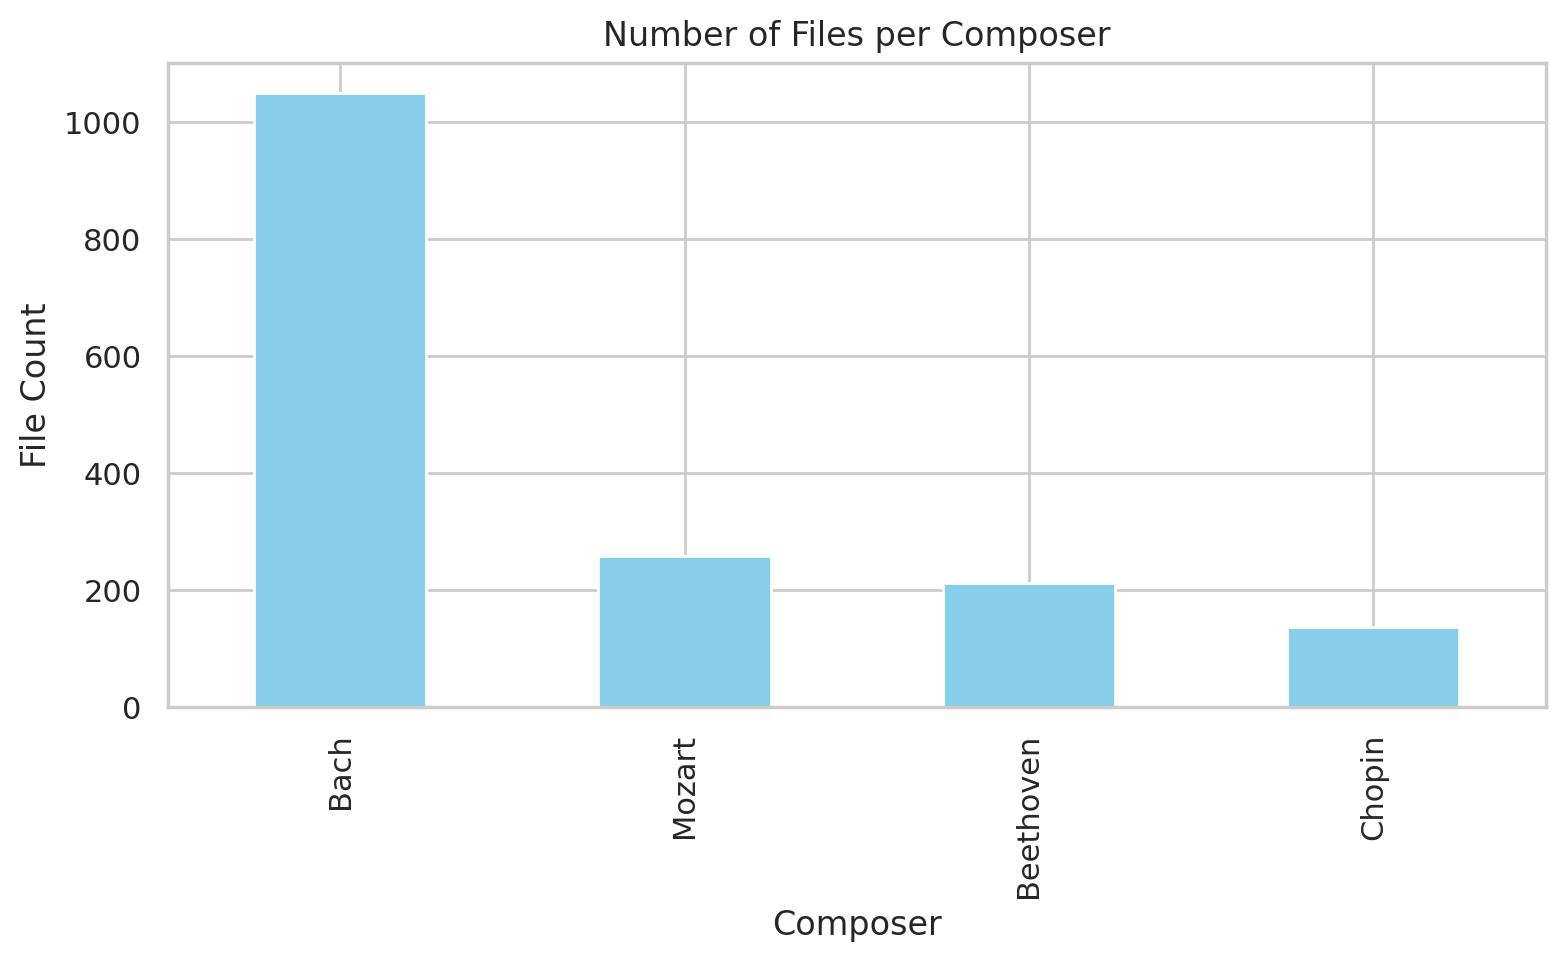

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# Number of files per composer
plt.figure(figsize=(8, 5))
composer_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Files per Composer')
plt.ylabel('File Count')
plt.xlabel('Composer')
plt.tight_layout()
plt.show()

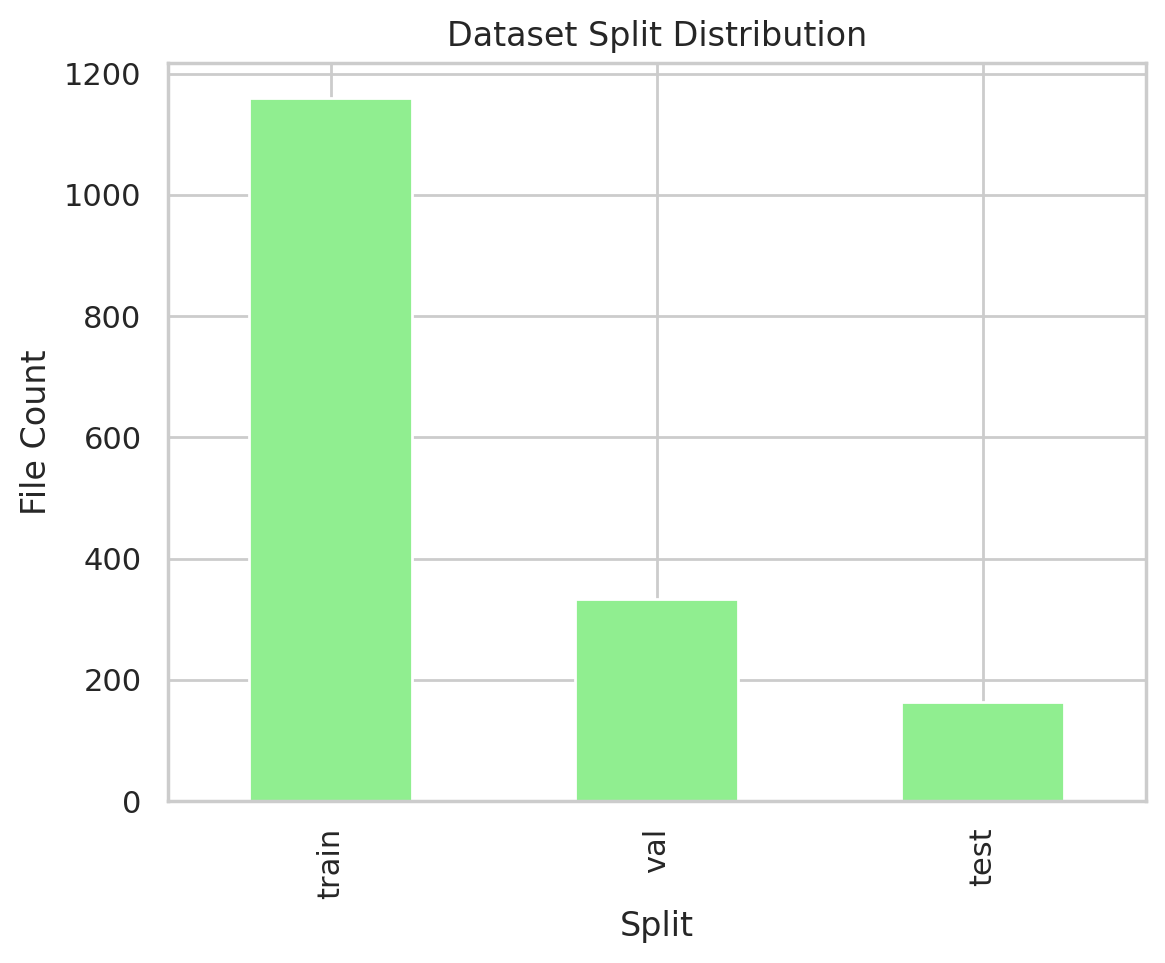

In [ ]:
# Split distribution
plt.figure(figsize=(6, 5))
split_counts.plot(kind='bar', color='lightgreen')
plt.title('Dataset Split Distribution')
plt.ylabel('File Count')
plt.xlabel('Split')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

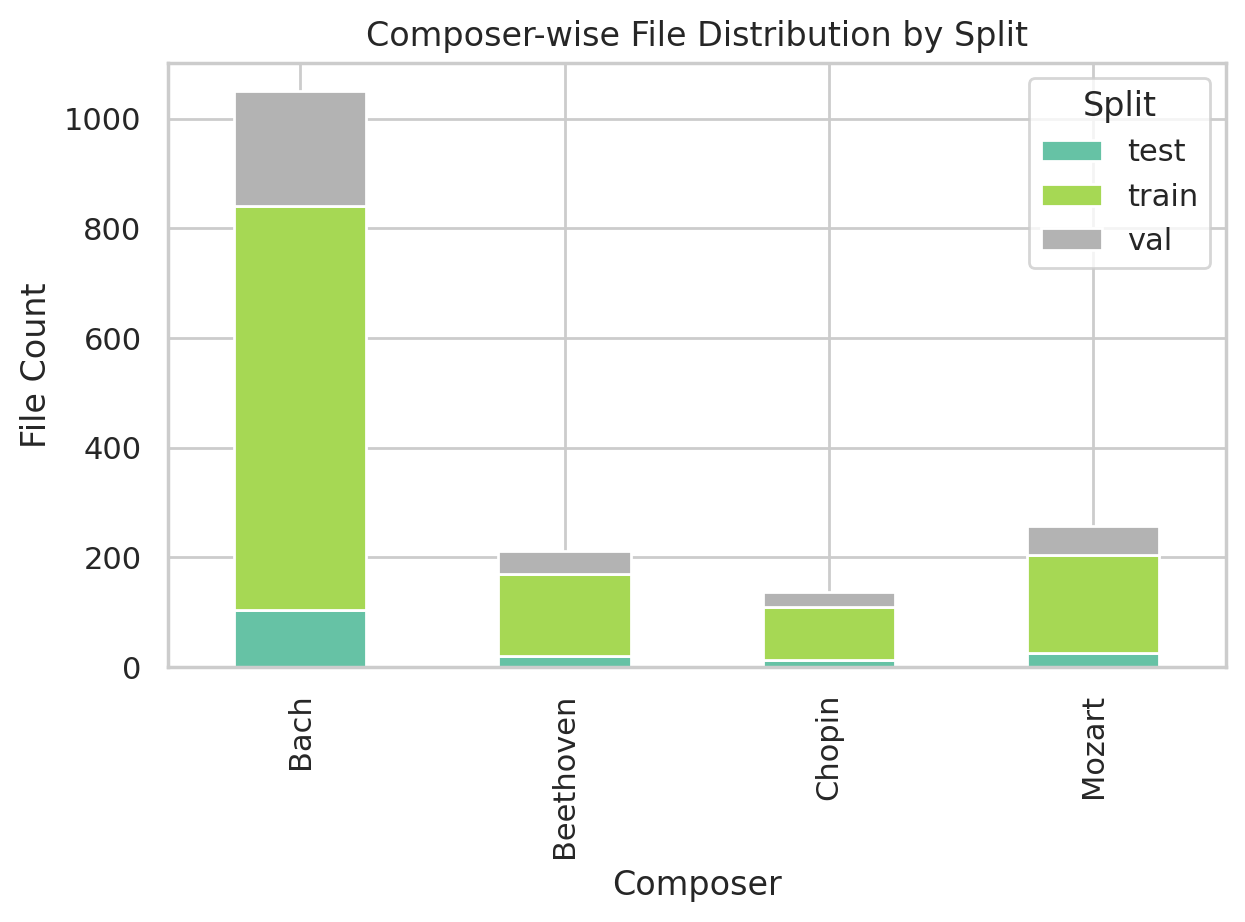

In [ ]:
# Composer-wise split
plt.figure(figsize=(10, 6))
composer_split_counts.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Composer-wise File Distribution by Split')
plt.ylabel('File Count')
plt.xlabel('Composer')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

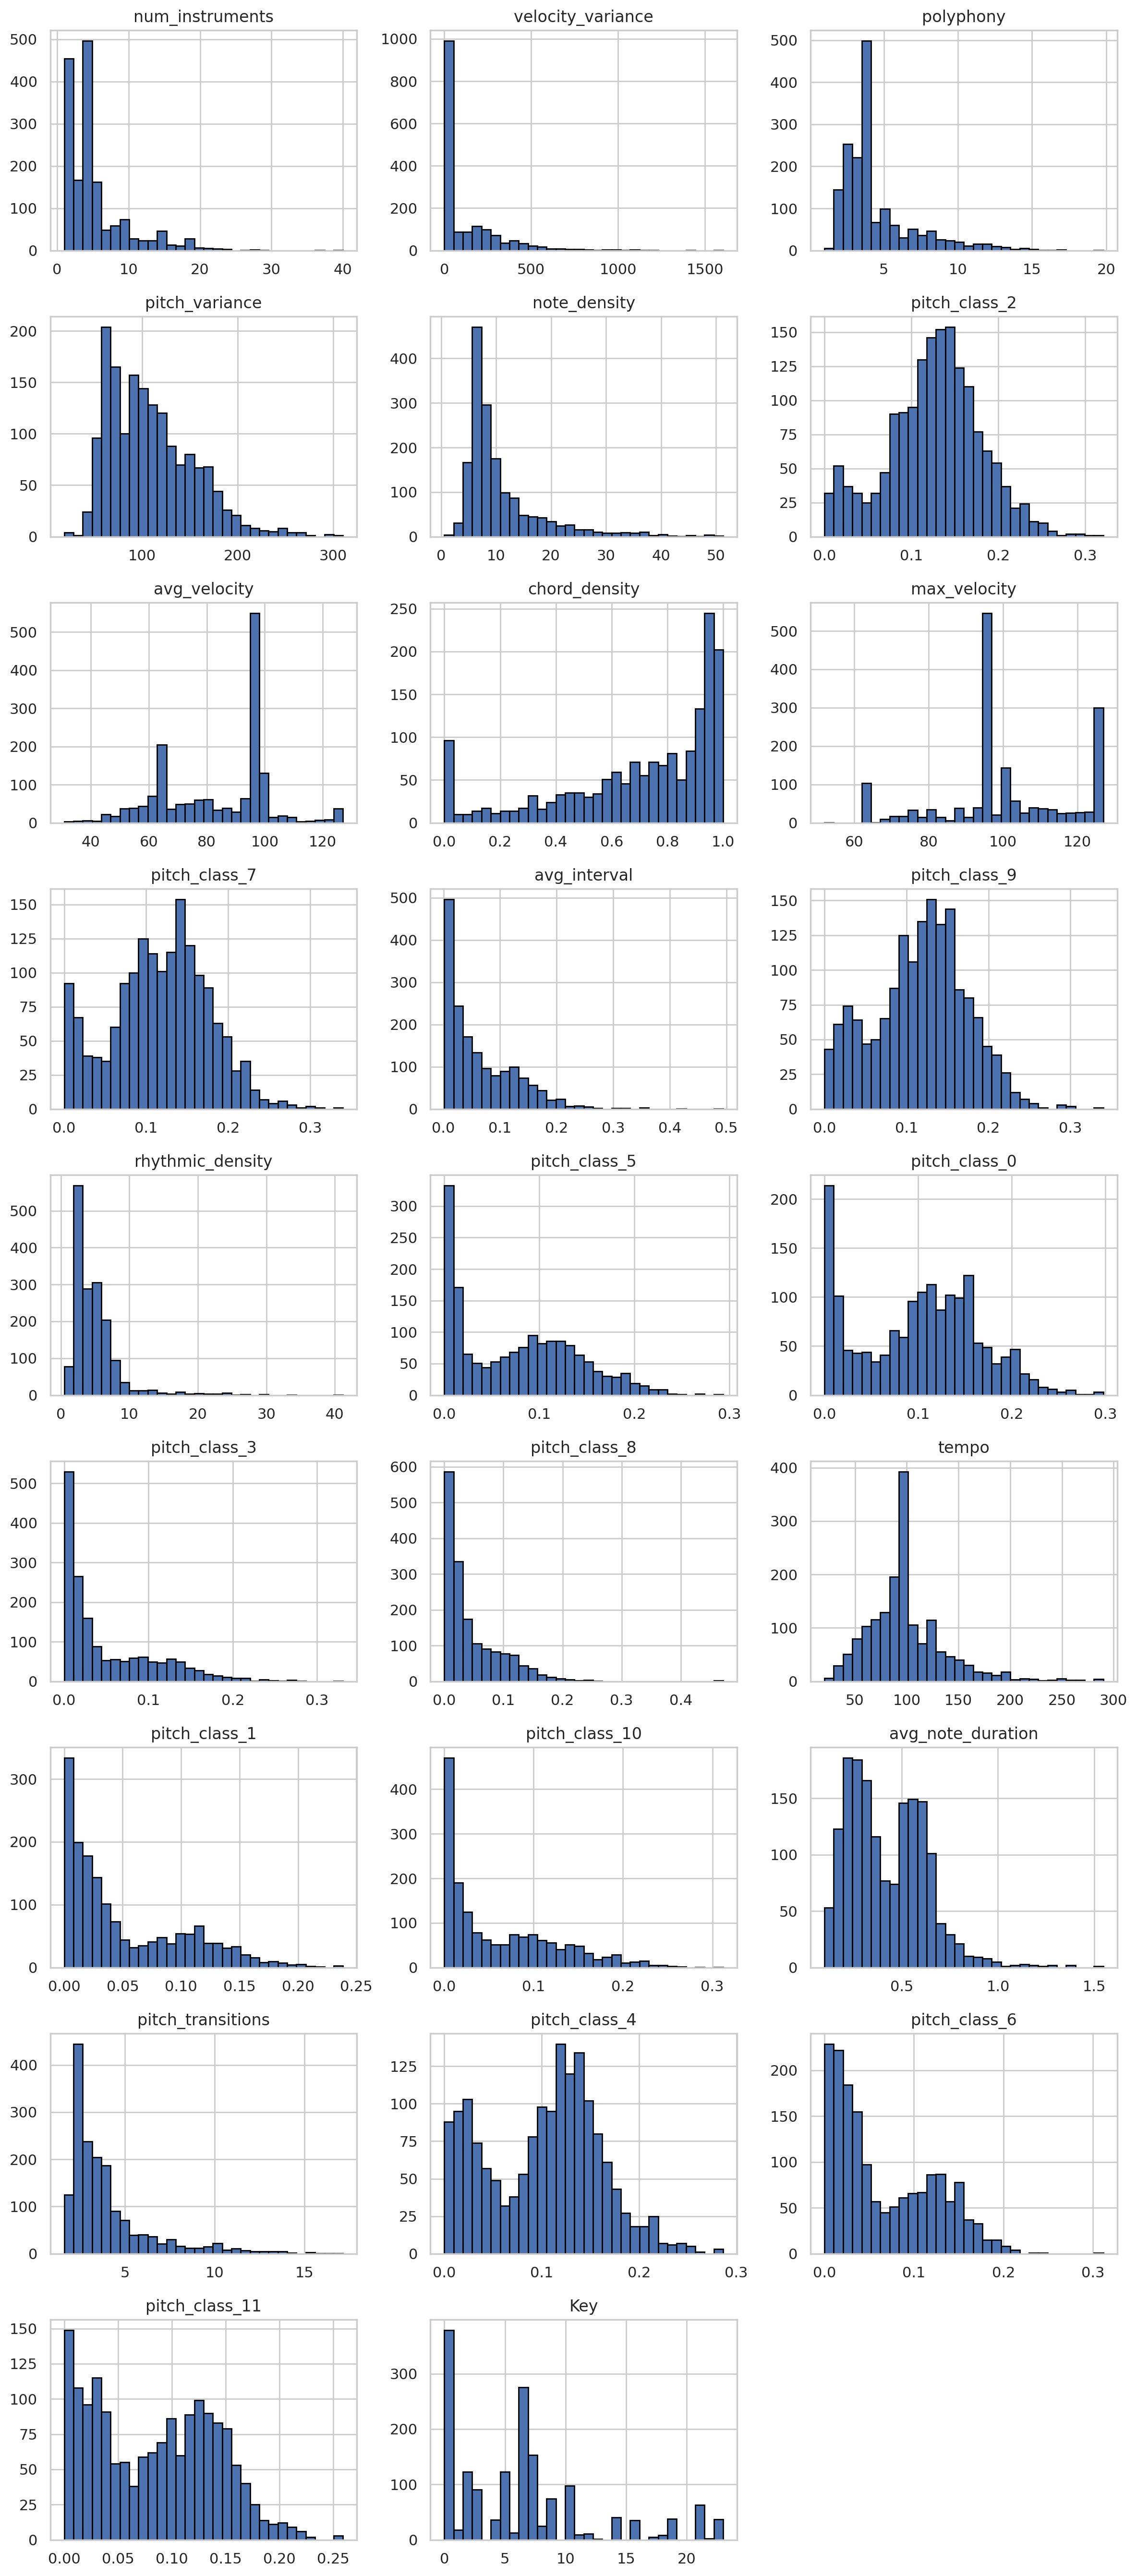

In [ ]:
# Features to plot
features = [
    "num_instruments", "velocity_variance", "polyphony", "pitch_variance", "note_density",
    "pitch_class_2", "avg_velocity", "chord_density", "max_velocity", "pitch_class_7",
    "avg_interval", "pitch_class_9", "rhythmic_density", "pitch_class_5", "pitch_class_0",
    "pitch_class_3", "pitch_class_8", "tempo", "pitch_class_1", "pitch_class_10",
    "avg_note_duration", "pitch_transitions", "pitch_class_4", "pitch_class_6", "pitch_class_11",
    "Key"
]

# Determine grid dimensions for subplots
n_features = len(features)
ncols = 3
nrows = int(np.ceil(n_features / ncols))

plt.figure(figsize=(ncols * 4, nrows * 3))

# Plot distributions for each statistical feature
for i, feature in enumerate(features):
    plt.subplot(nrows, ncols, i + 1)
    data = df[feature].dropna()
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(feature)
    plt.tight_layout()

plt.show()

### Correlation analysis

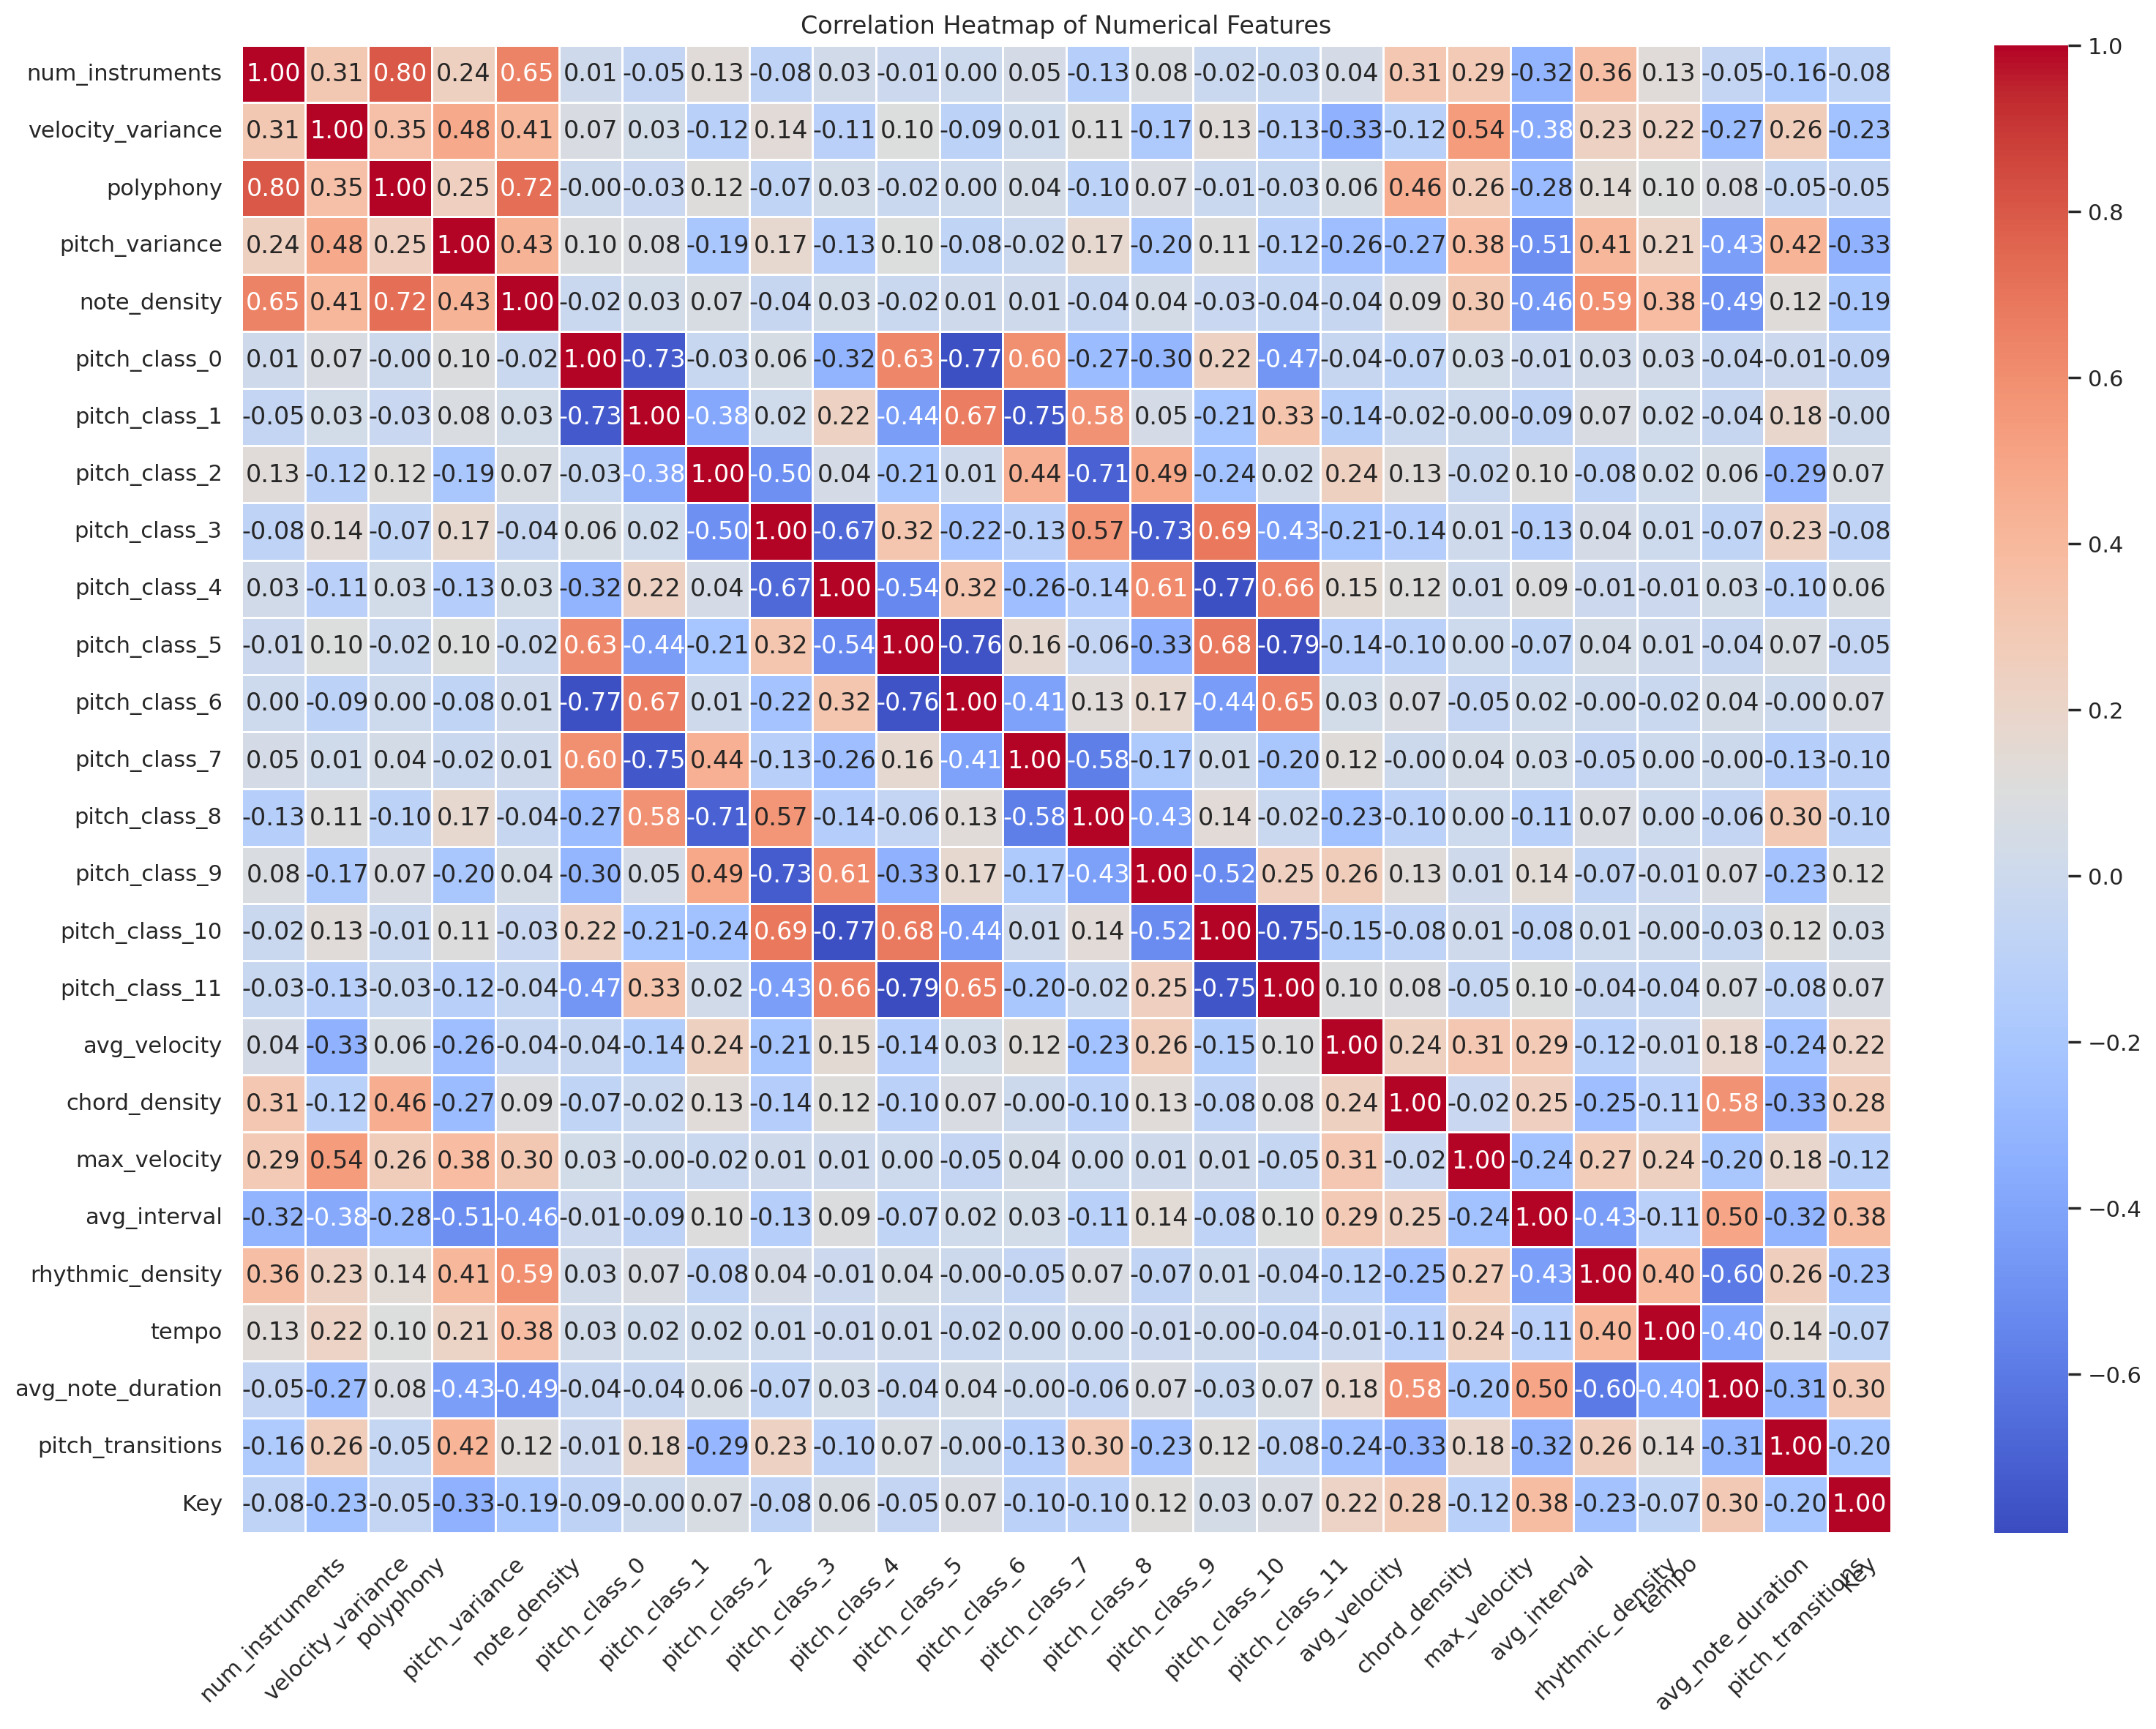

In [ ]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

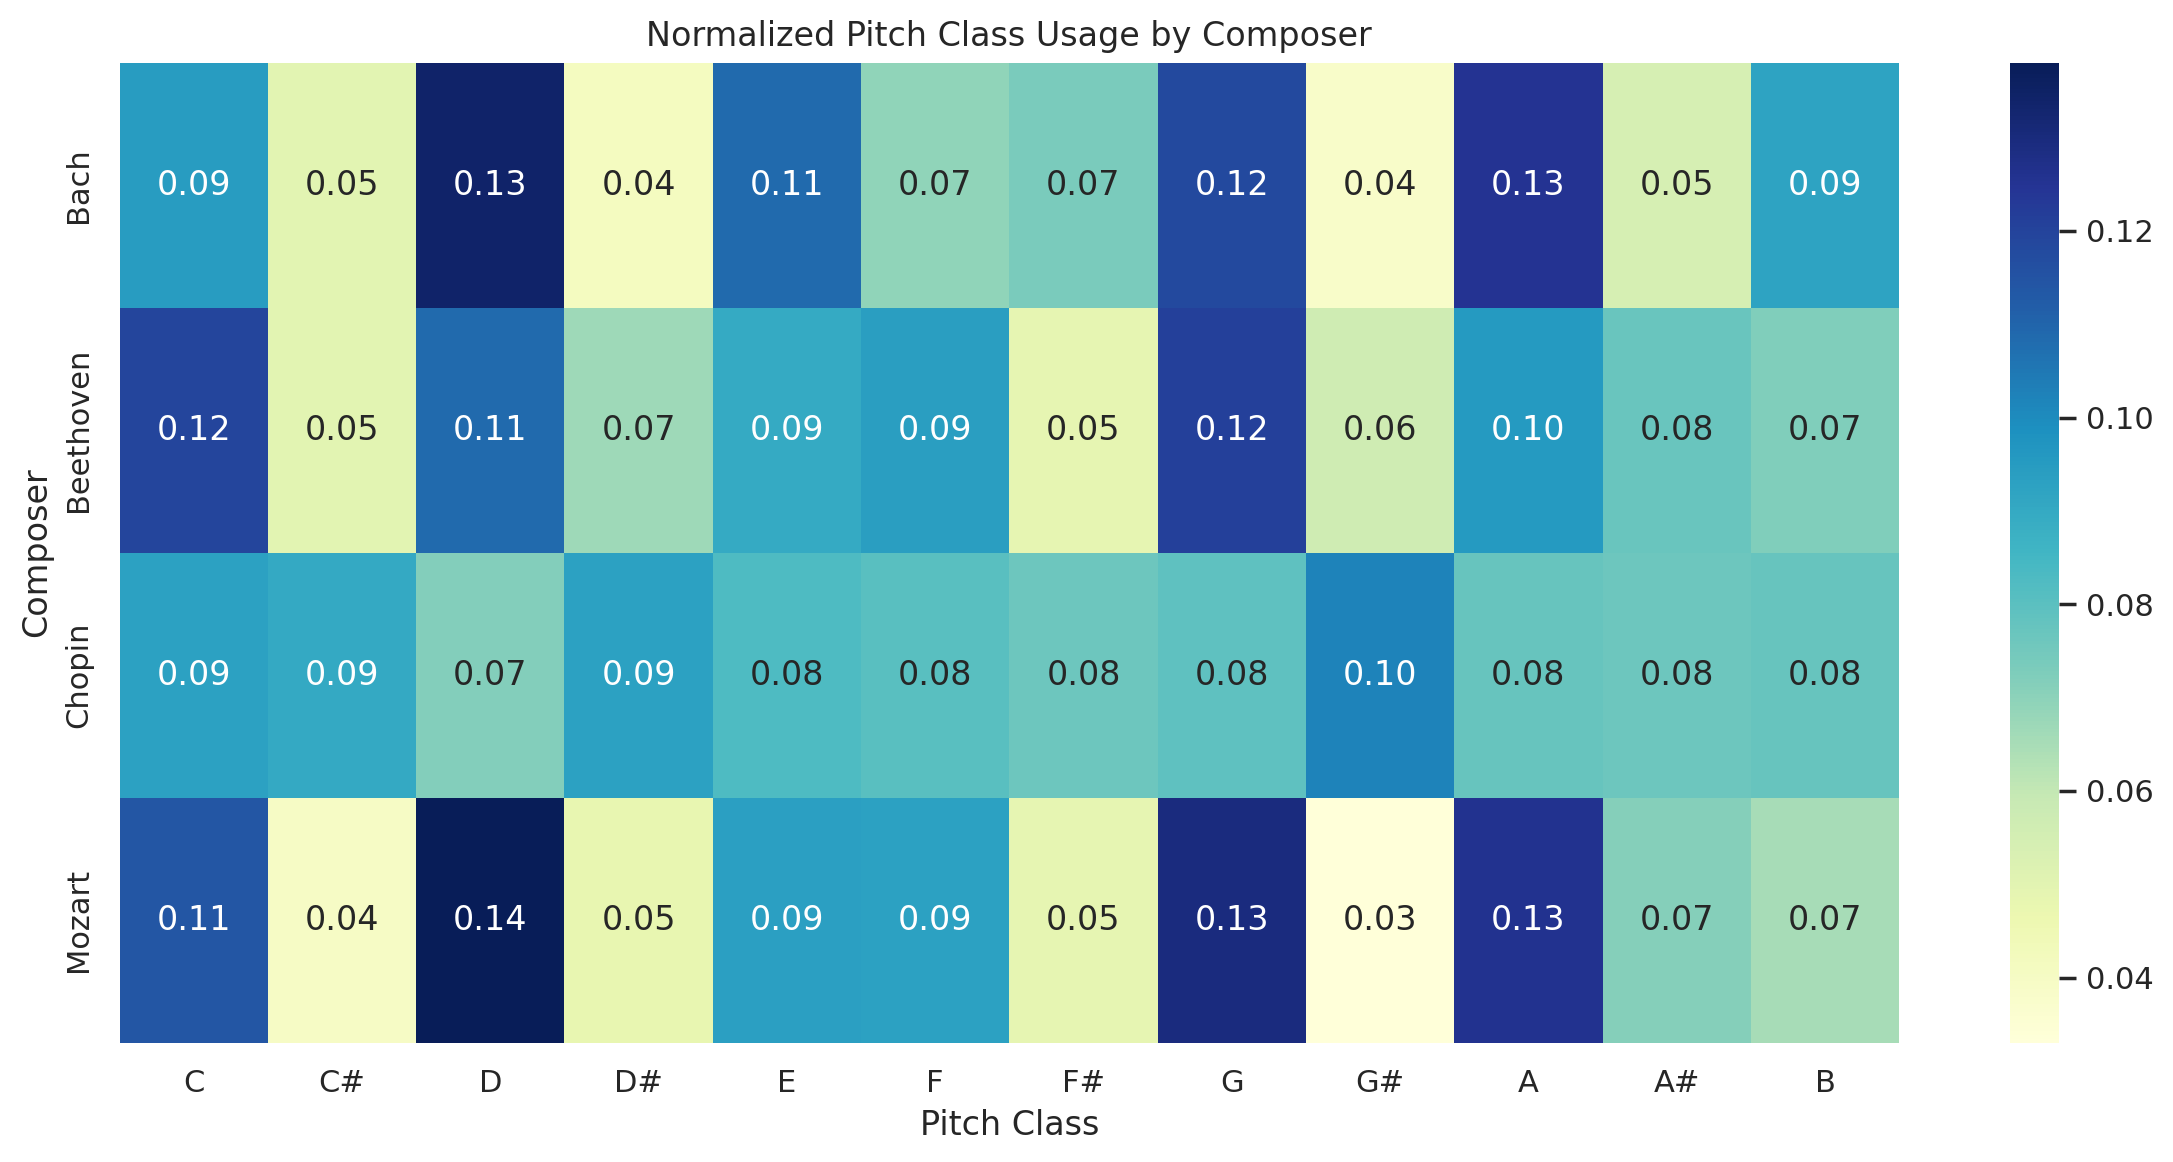

In [ ]:
# Normalize pitch class usage by composer
pitch_classes = [f'pitch_class_{i}' for i in range(12)]
df_pitch = df.groupby('composer')[pitch_classes].mean()
df_pitch_normalized = df_pitch.div(df_pitch.sum(axis=1), axis=0)

# Rename columns to note names
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
df_pitch_normalized.columns = note_names

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(df_pitch_normalized, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Normalized Pitch Class Usage by Composer")
plt.xlabel("Pitch Class")
plt.ylabel("Composer")
plt.tight_layout()
plt.show()

## LSTM Model Building

### Base LSTM model

In [ ]:
def create_sequences(data, targets, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(targets[i+seq_length])
    return np.array(X), np.array(y)

# Normalize the feature data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Encode labels (composer classification)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['composer'])

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length=5)

print("Input shape:", X_seq.shape)
print("Target shape:", y_seq.shape)


Input shape: (1652, 5, 26)
Target shape: (1652,)


In [ ]:

lstm_model = Sequential([
    Input(shape=(5, 26), dtype='int32'),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_seq)), activation='softmax')  # For classification
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,508 (99.64 KB)

 Trainable params: 25,508 (99.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

history = lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4318 - loss: 1.2881 - val_accuracy: 0.7915 - val_loss: 0.7177
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7904 - loss: 0.6365 - val_accuracy: 0.9063 - val_loss: 0.3519
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8818 - loss: 0.3687 - val_accuracy: 0.9094 - val_loss: 0.2570
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8998 - loss: 0.3285 - val_accuracy: 0.9245 - val_loss: 0.1950
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9164 - loss: 0.2421 - val_accuracy: 0.9396 - val_loss: 0.1655
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9278 - loss: 0.2100 - val_accuracy: 0.9426 - val_loss: 0.1477
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9349 - loss: 0.1938 - val_accuracy: 0.9456 - val_loss: 0.1441
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9453 - loss: 0.1711 - val_accuracy: 0.9577 - val_loss

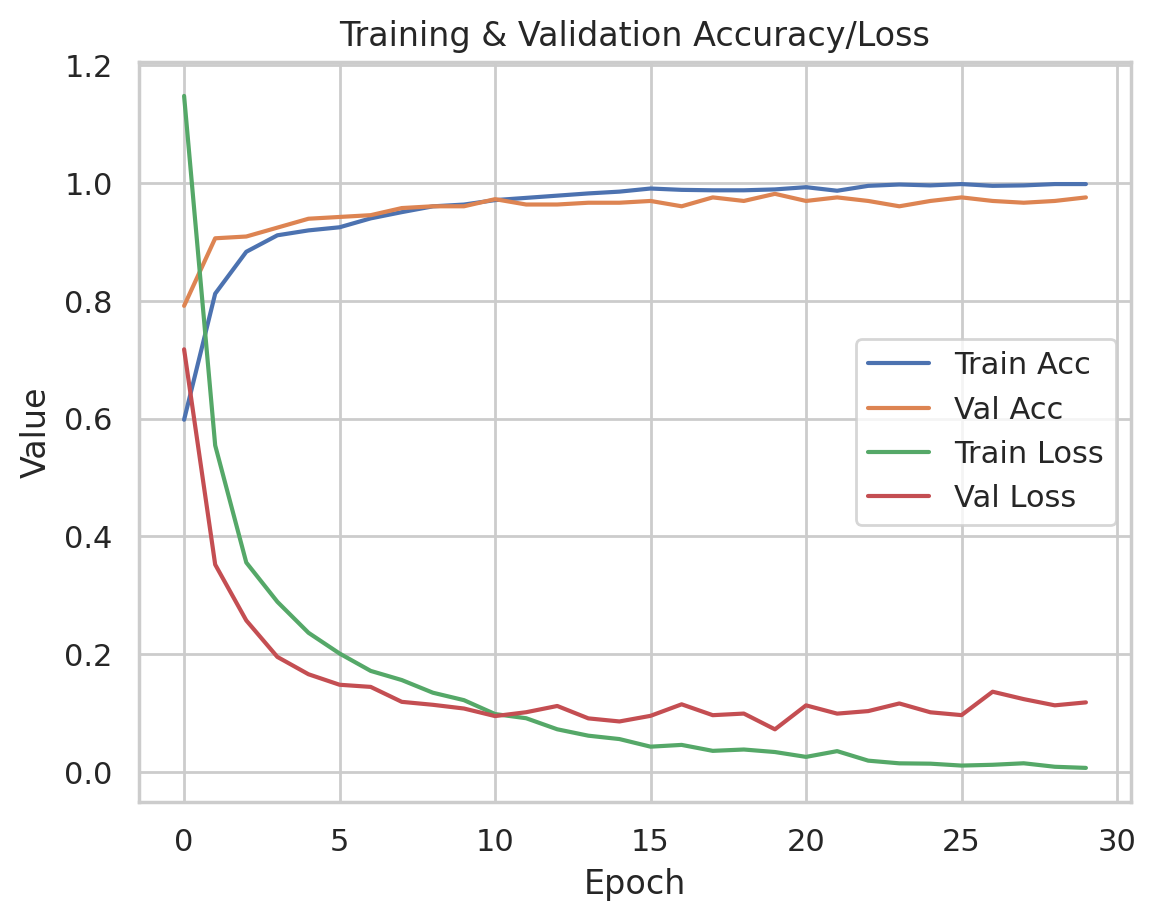

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Accuracy/Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## LSTM Model Evaluation

In [ ]:

y_pred = lstm_model.predict(X_val)

# Convert to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

        Bach       1.00      0.99      0.99       210
   Beethoven       0.91      0.98      0.94        43
      Chopin       1.00      0.96      0.98        27
      Mozart       0.94      0.92      0.93        51

    accuracy                           0.98       331
   macro avg       0.96      0.96      0.96       331
weighted avg       0.98      0.98      0.98       331



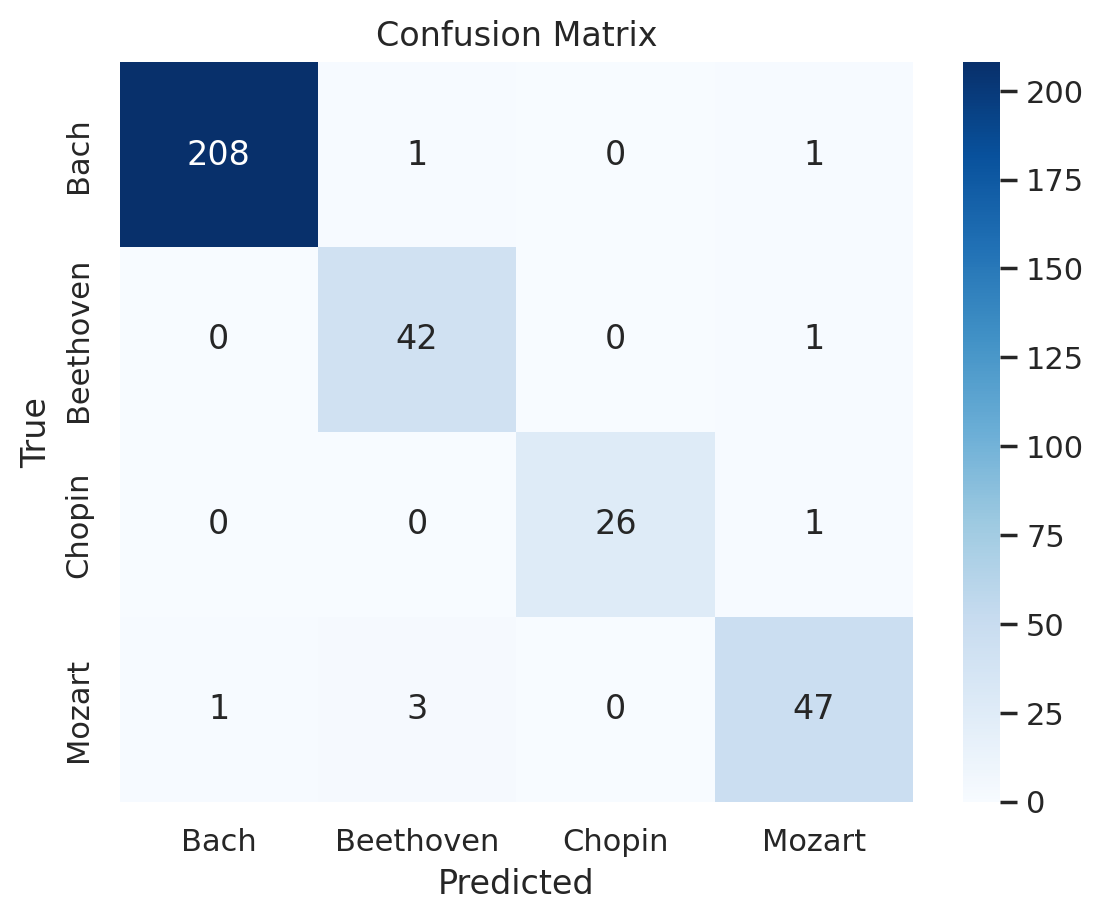

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## LSTM Model Optimization

In [ ]:
lstm_opt_model = Sequential([
    Input(shape=(5, 26), dtype='int32'),
    LSTM(15, return_sequences=True, recurrent_dropout=0.4),
    BatchNormalization(),
    LSTM(15, return_sequences=False, recurrent_dropout=0.4),
    BatchNormalization(),
    Dropout(0.4),
    BatchNormalization(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(np.unique(y_seq)), activation='softmax')  # For classification
])

lstm_opt_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_opt_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 5, 15)          │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 15)          │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 15)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,684 (18.30 KB)

 Trainable params: 4,564 (17.83 KB)

 Non-trainable params: 120 (480.00 B)

In [ ]:
history = lstm_opt_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3235 - loss: 1.7525 - val_accuracy: 0.7160 - val_loss: 1.2664
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5041 - loss: 1.2051 - val_accuracy: 0.7402 - val_loss: 1.1079
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6265 - loss: 1.0064 - val_accuracy: 0.7523 - val_loss: 0.9364
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6816 - loss: 0.8594 - val_accuracy: 0.7674 - val_loss: 0.7744
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7262 - loss: 0.7511 - val_accuracy: 0.7946 - val_loss: 0.6604
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7780 - loss: 0.6166 - val_accuracy: 0.8248 - val_loss: 0.5629
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7974 - loss: 0.5759 - val_accuracy: 0.8308 - val_loss: 0.4964
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7888 - loss: 0.5373 - val_accuracy: 0.8640 - val_

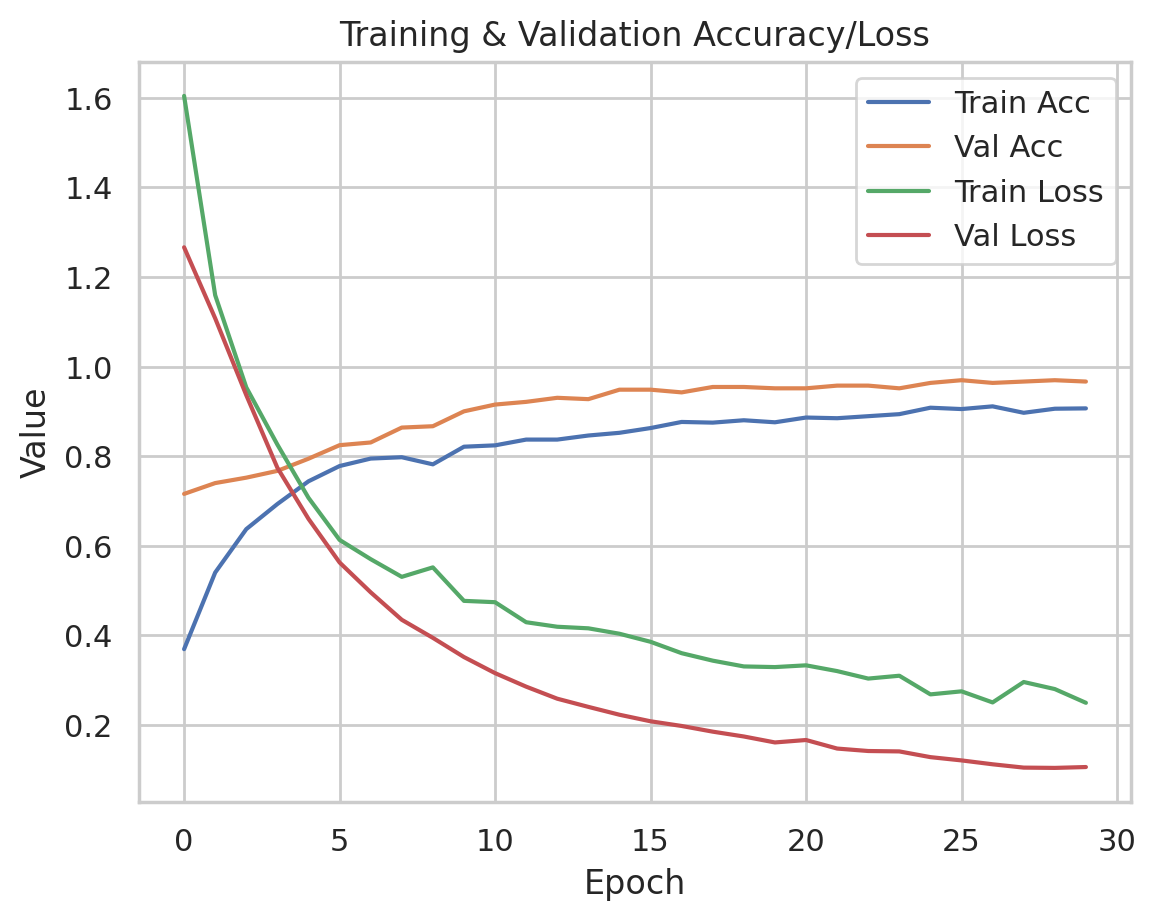

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Accuracy/Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred = lstm_opt_model.predict(X_val)

# Convert to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
              precision    recall  f1-score   support

        Bach       0.99      1.00      0.99       210
   Beethoven       0.93      0.93      0.93        43
      Chopin       0.87      1.00      0.93        27
      Mozart       0.98      0.86      0.92        51

    accuracy                           0.97       331
   macro avg       0.94      0.95      0.94       331
weighted avg       0.97      0.97      0.97       331



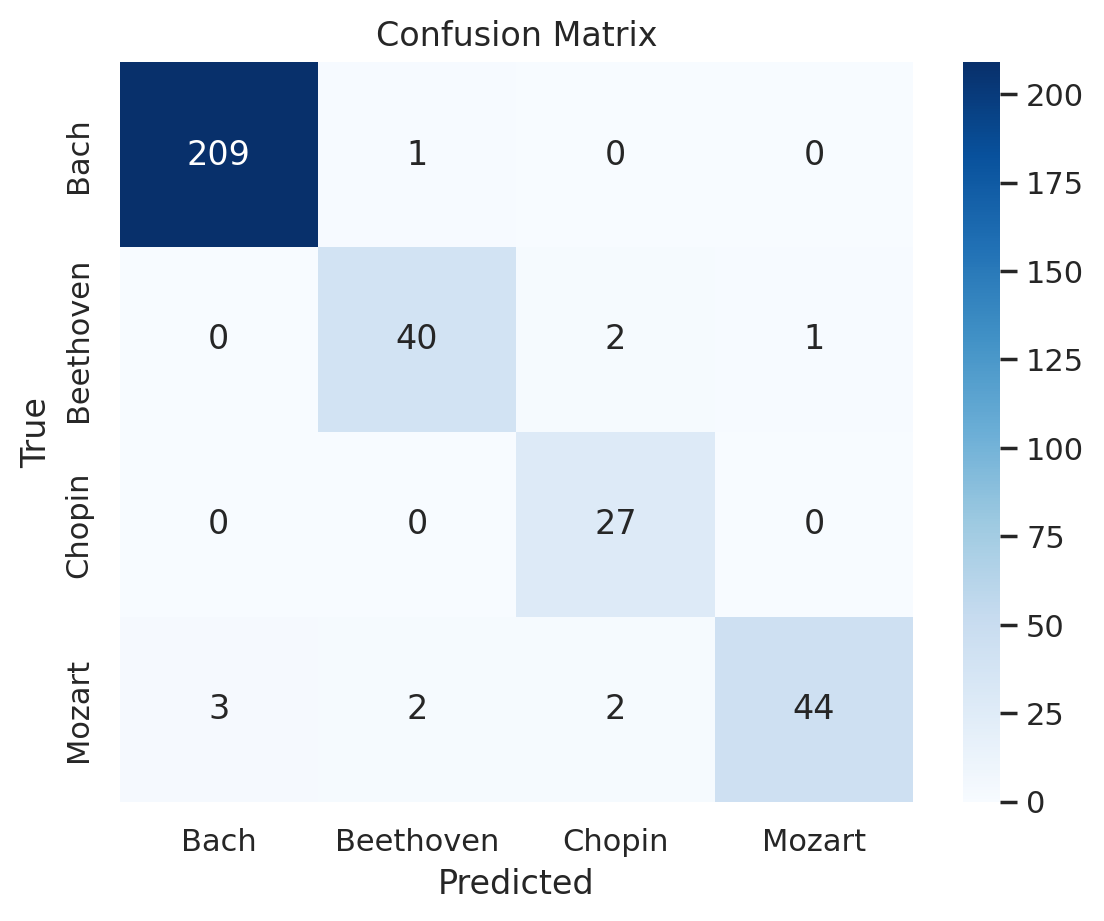

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## CNN Model Building

### Additional Features for CNN

In [5]:
# Load dataset
df = pd.read_csv(csv_file)

# Output directory for WAV and Mel
out_path = os.path.join(dataset_path, 'mel_spectrograms')
mel_csv_file = os.path.join(dataset_path,'mel_spectrogram_index.csv')

os.makedirs(out_path, exist_ok=True)


In [ ]:
# Convert MIDI to WAV
#def midi_to_audio(midi_path):
#    try:
#        midi_data = pretty_midi.PrettyMIDI(midi_path)
#        audio = midi_data.fluidsynth()
#        return audio, 44100  # Default sample rate
#    except Exception as e:
#        print(f"Failed to convert {midi_path}: {e}")
#        return None, None

def midi_to_audio(midi_path, trim_silence=True, save_wav_path=None, top_db=60):
    """
    Converts a MIDI file to audio using FluidSynth.

    Parameters:
        midi_path (str): Path to MIDI file.
        trim_silence (bool): Whether to trim leading/trailing silence.
        save_wav_path (str): If provided, saves the audio to a WAV file.
        top_db (int): Threshold in dB for trimming silence.

    Returns:
        Tuple: (audio numpy array, sample_rate)
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        audio = midi_data.fluidsynth()
        sr = 44100  # Default sample rate

        if trim_silence:
            audio, _ = librosa.effects.trim(audio, top_db=top_db)

        if save_wav_path:
            sf.write(save_wav_path, audio, sr)

        return audio, sr

    except Exception as e:
        print(f"Failed to convert {midi_path}: {e}")
        return None, None


In [ ]:
def pad_or_crop(matrix, target_length):
    """
    Pad or crop a 2D feature matrix along the time axis (axis=1) to have shape (n_features, target_length)
    """
    current_length = matrix.shape[1]
    if current_length > target_length:
        return matrix[:, :target_length]
    elif current_length < target_length:
        return np.pad(matrix, ((0, 0), (0, target_length - current_length)), mode='constant')
    else:
        return matrix

In [ ]:
# Extract Mel Spectrogram
#def extract_mel(audio, sr, n_mels=128):
#    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
#    S_db = librosa.power_to_db(S, ref=np.max)
#    return S_db

def extract_combined_features(audio, sr, n_mels=128, n_mfcc=13, time_steps=256):
    """
    Extract combined features (Mel spectrogram + MFCCs) stacked as multi-channel input.

    Returns:
        combined: np.ndarray of shape (time_steps, n_mels, 2)
    """
    # Extract Mel spectrogram
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)  # shape: (n_mels, T)

    # Extract MFCCs (from mel spectrogram by default)
    mfcc = librosa.feature.mfcc(S=mel_db, sr=sr, n_mfcc=n_mfcc)  # shape: (n_mfcc, T)

    # Pad/crop to match expected time_steps
    mel_db = pad_or_crop(mel_db, time_steps)
    mfcc = pad_or_crop(mfcc, time_steps)

    # Transpose both to (time_steps, features)
    mel_db = mel_db.T  # shape: (time_steps, n_mels)
    mfcc = mfcc.T      # shape: (time_steps, n_mfcc)

    # Pad MFCC to match mel's second dimension if needed
    if mfcc.shape[1] < n_mels:
        pad_width = n_mels - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    elif mfcc.shape[1] > n_mels:
        mfcc = mfcc[:, :n_mels]

    # Stack as multi-channel input: shape (time_steps, n_mels, 2)
    combined = np.stack((mel_db, mfcc), axis=-1)

    return combined


In [ ]:
# Extract Mel Spectrogram from Midi files
'''
mel_specs = []
labels = []
paths = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    midi_path = os.path.join(dataset_path, row['filepath'])
    composer = row['composer']
    try:
        audio, sr = midi_to_audio(midi_path)
        if audio is None:
            continue
        mel = extract_mel(audio, sr)

        # Optional: resize or pad mel to fixed shape (e.g., [128, 256])
        if mel.shape[1] < 256:
            pad_width = 256 - mel.shape[1]
            mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel = mel[:, :256]  # Crop

        # Save as .npy
        out_name = os.path.join(out_path, os.path.basename(midi_path).replace('.mid', '.npy'))
        np.save(out_name, mel)

        mel_specs.append(out_name)
        labels.append(composer)
        paths.append(midi_path)

    except Exception as e:
        print(f"Error processing {midi_path}: {e}")

# Save metadata index
output_df = pd.DataFrame({
    'mel_path': mel_specs,
    'composer': labels,
    'original_midi': paths
})

output_df.to_csv(mel_csv_file, index=False)
'''
# Extract Mel Spectrogram + MFCC from Midi files
mel_specs = []
labels = []
paths = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    midi_path = os.path.join(dataset_path, row['filepath'])
    composer = row['composer']

    try:
        audio, sr = midi_to_audio(midi_path)
        if audio is None:
            continue

        combined = extract_combined_features(audio, sr)  # shape: (256, 128, 2)

        # Save as .npy
        out_name = os.path.join(out_path, os.path.basename(midi_path).replace('.mid', '.npy'))
        np.save(out_name, combined)

        mel_specs.append(out_name)
        labels.append(composer)
        paths.append(midi_path)

    except Exception as e:
        print(f"Error processing {midi_path}: {e}")

# Save metadata index
output_df = pd.DataFrame({
    'mel_path': mel_specs,
    'composer': labels,
    'original_midi': paths
})
output_df.to_csv(mel_csv_file, index=False)


  1%|▎                                     | 12/1660 [01:28<4:02:43,  8.84s/it]

Failed to convert ./Kaggle_Composer_Dataset/train/Mozart/Mozart_0048.mid: Could not decode key with 2 flats and mode 2


  5%|██                                    | 90/1660 [13:12<3:26:41,  7.90s/it]fluidsynth: Successfully configured channel group, from channel 0 up to including chan 125 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 124 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 120 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 117 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 114 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 109 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 106 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 105 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 99 to mode

Failed to convert ./Kaggle_Composer_Dataset/val/Chopin/Chopin_0137.mid: MThd not found. Probably not a MIDI file


 86%|███████████████████████████████     | 1430/1660 [1:53:12<20:49,  5.43s/it]

Failed to convert ./Kaggle_Composer_Dataset/val/Beethoven/Beethoven_0004.mid: Could not decode key with 3 flats and mode 255


100%|████████████████████████████████████| 1660/1660 [2:00:03<00:00,  4.34s/it]


In [7]:
# Load mel spectrogram metadata
df_mel = pd.read_csv(mel_csv_file)

# Show structure
df_mel.head()

mel_path composer  \
0  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   
1  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   
2  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   
3  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   
4  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   

                                       original_midi  
0  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...  
1  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...  
2  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...  
3  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...  
4  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...

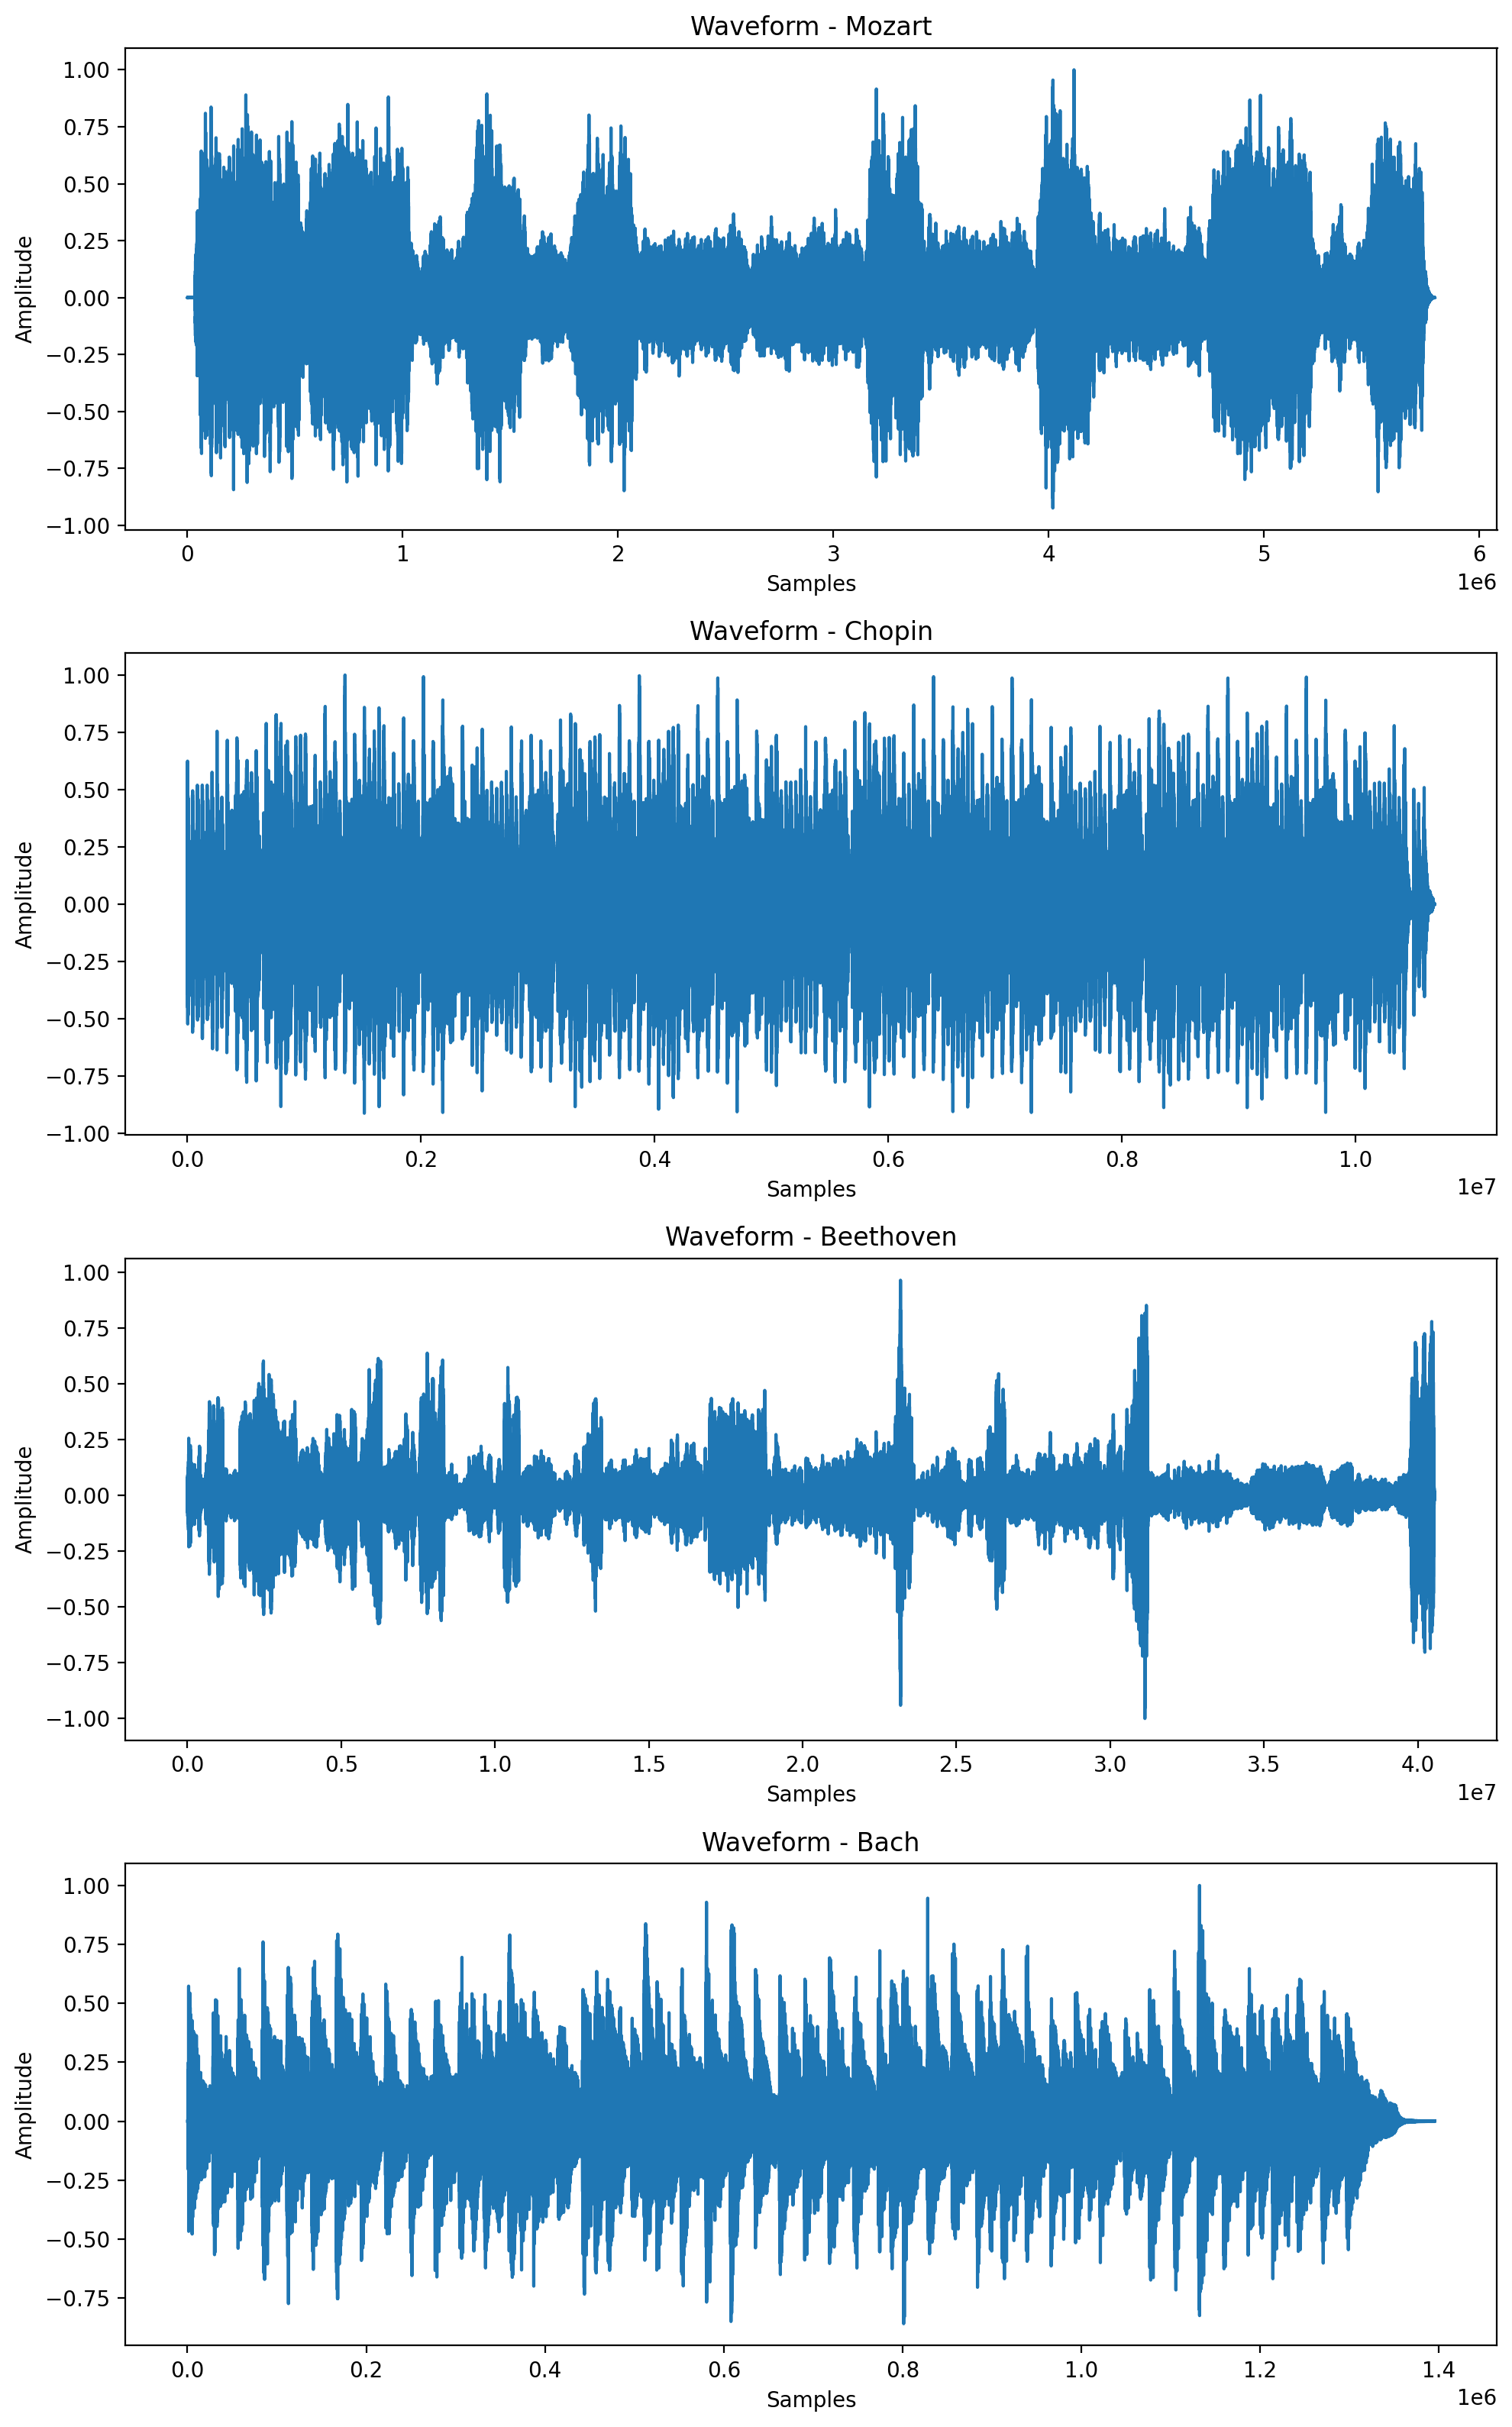

In [ ]:
# Pick composers
selected_composers = df['composer'].unique()[:4]

plt.figure(figsize=(10, 16))

for i, composer in enumerate(selected_composers):
    row = df_mel[df_mel['composer'] == composer].iloc[0]
    midi_path = os.path.join(root_path, row['original_midi'])
    midi_path = os.path.normpath(midi_path)

    try:
        audio, sr = midi_to_audio(midi_path)

        ax = plt.subplot(4, 1, i + 1)
        ax.plot(audio)
        ax.set_title(f"Waveform - {composer}")
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude")

    except Exception as e:
        print(f"Error converting {midi_path}: {e}")

plt.tight_layout()
plt.show()


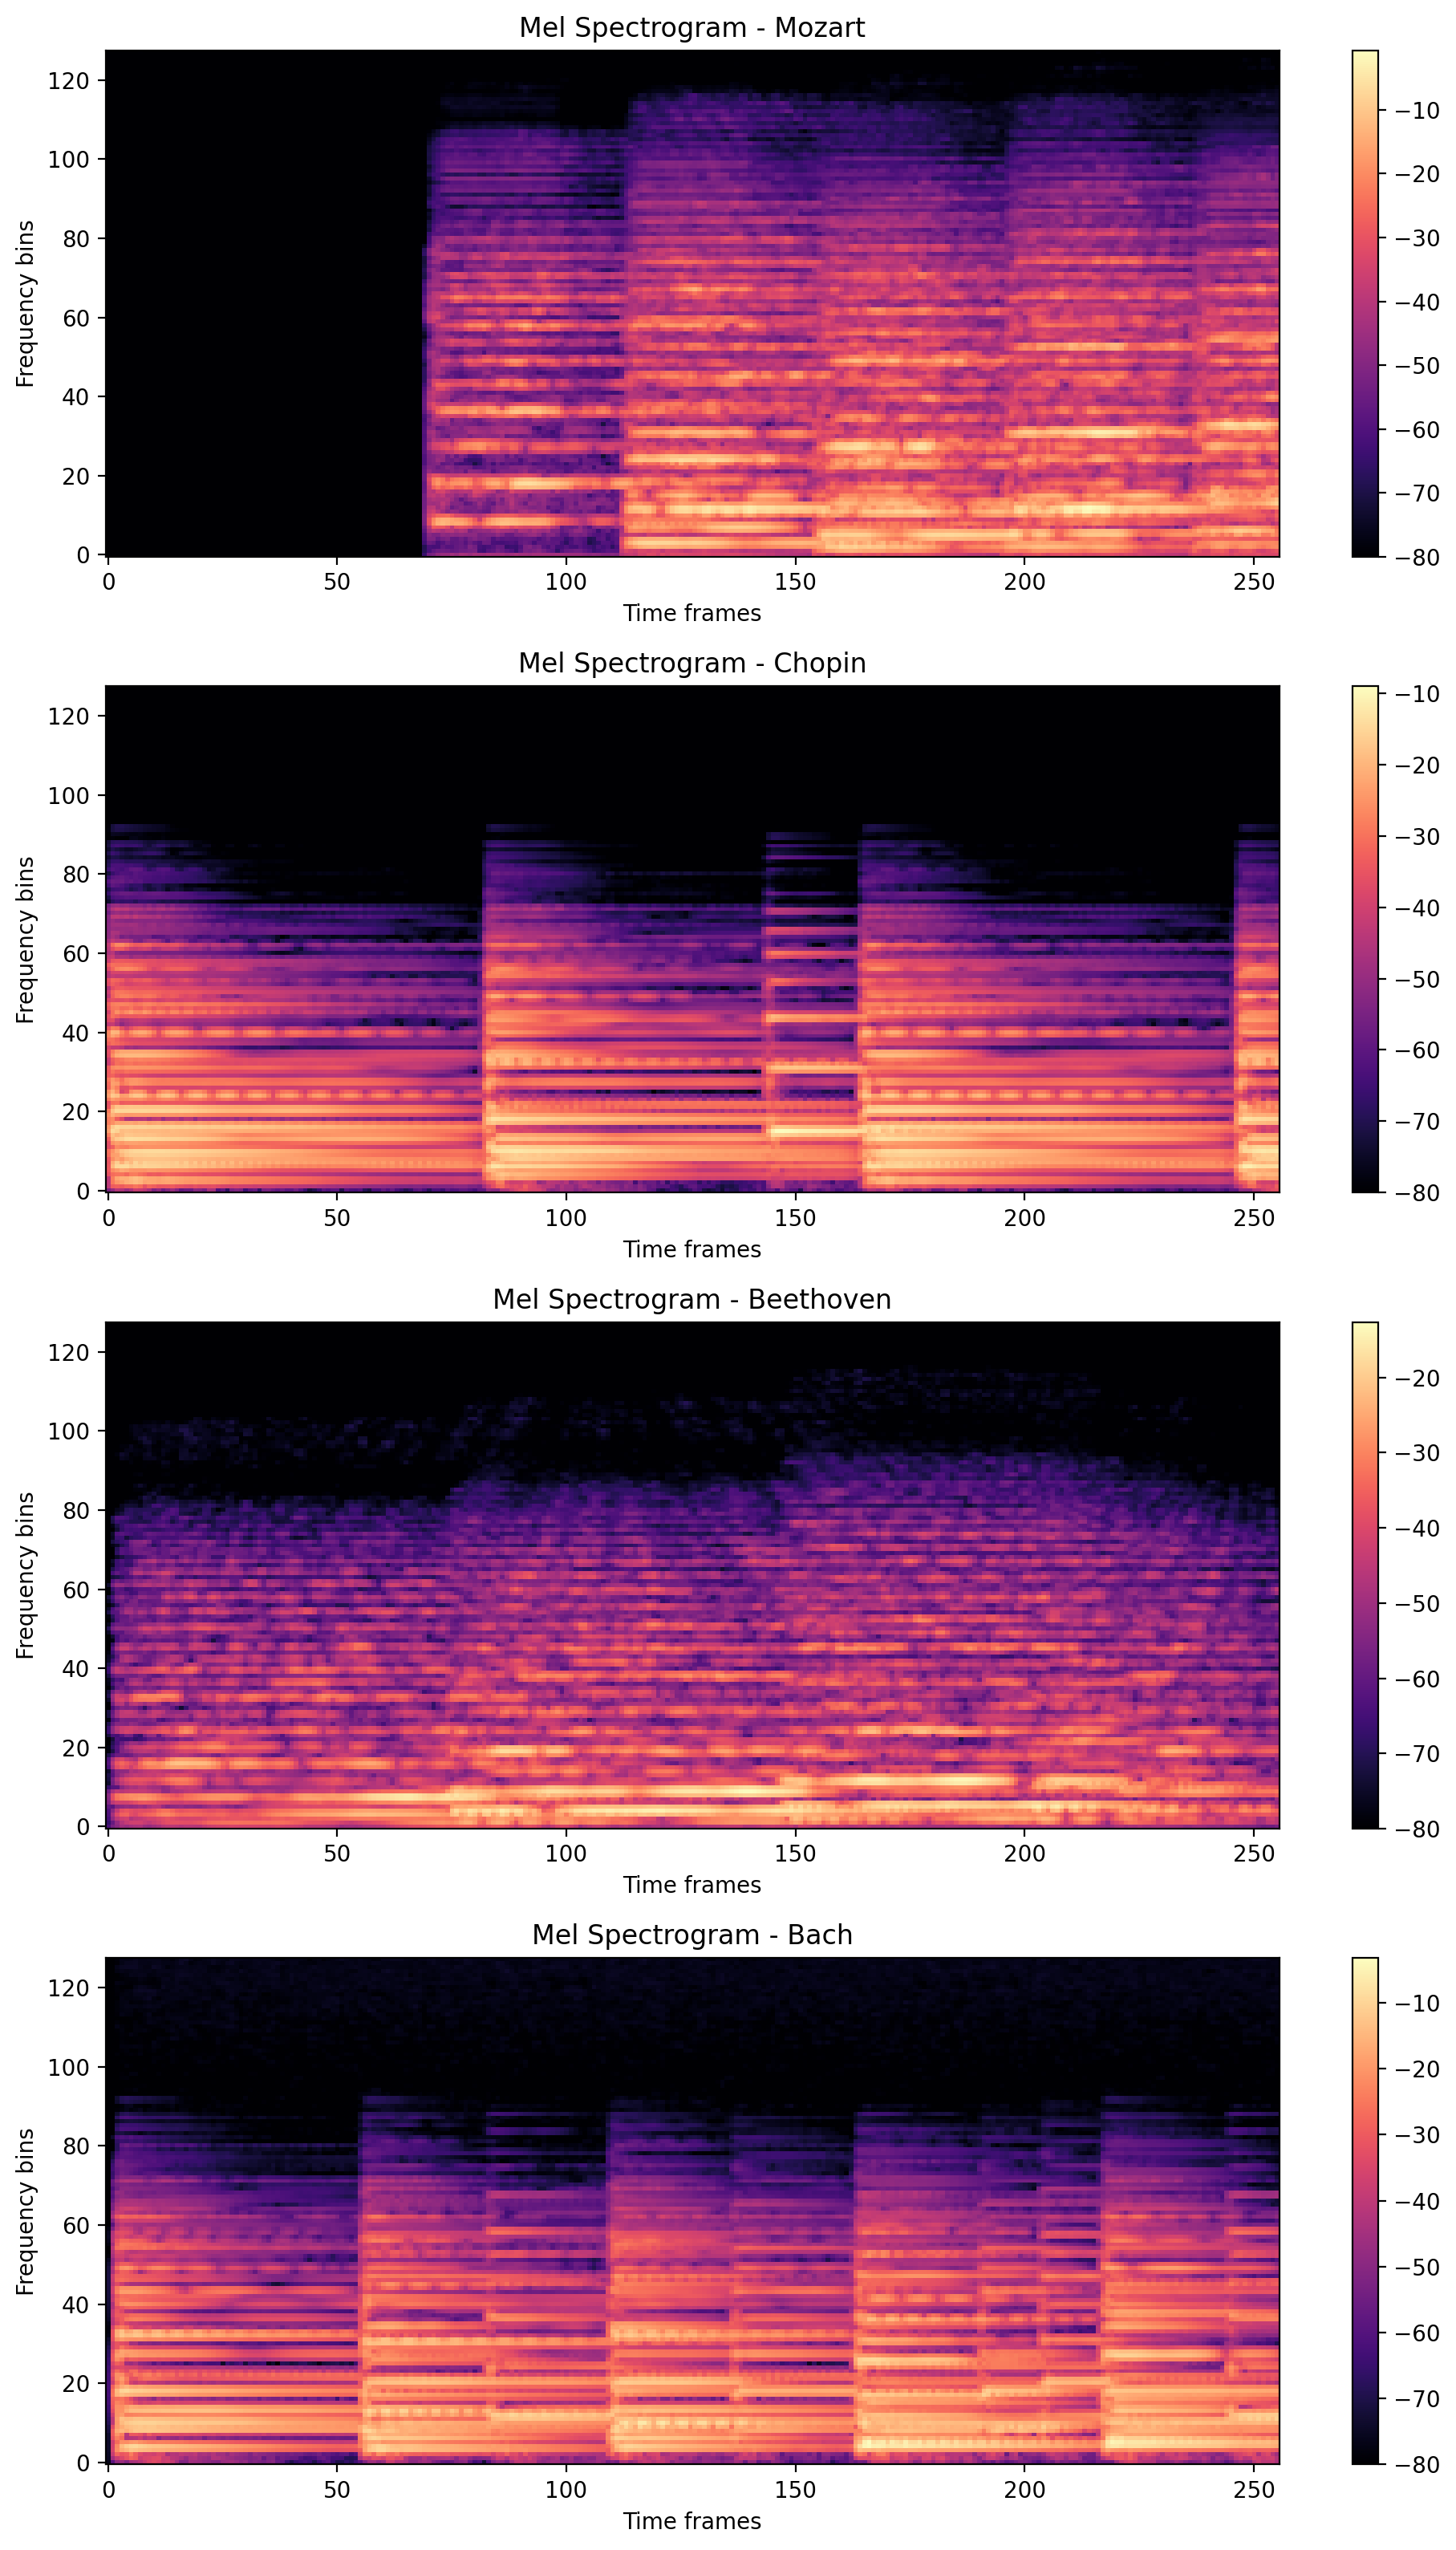

In [ ]:
# Plot Mel spectrograms
plt.figure(figsize=(10, 16))  # Adjust height for 4 subplots
for i, composer in enumerate(selected_composers):
    sample_row = df_mel[df_mel['composer'] == composer].iloc[0]
    mel_path = os.path.join(root_path, sample_row['mel_path'])
    mel_path = os.path.normpath(mel_path)

    combined = np.load(mel_path)
    mel = combined[:, :, 0]  # Mel channel

    ax = plt.subplot(4, 1, i + 1)
    im = ax.imshow(mel.T, origin='lower', aspect='auto', cmap='magma')
    ax.set_title(f"Mel Spectrogram - {composer}")
    ax.set_ylabel("Frequency bins")
    ax.set_xlabel("Time frames")
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


### Data Pre-processing

In [8]:
'''
# Fixed shape for Mel spectrograms
N_MELS = 128
TIME_STEPS = 256
EXPECTED_SHAPE = (TIME_STEPS, N_MELS)  # after transpose

# Prepare arrays
X = []
y = []

# Iterate over metadata
for _, row in tqdm(df_mel.iterrows(), total=len(df_mel)):
    mel_path = row["mel_path"]
    label = row["composer"]

    try:
        mel = np.load(mel_path)

        # Ensure shape is (256, 128)
        if mel.shape != (N_MELS, TIME_STEPS):
            # Transpose or pad/crop
            mel = mel[:, :TIME_STEPS] if mel.shape[1] > TIME_STEPS else np.pad(mel, ((0, 0), (0, TIME_STEPS - mel.shape[1])), mode='constant')
        mel = mel.T

        X.append(mel)
        y.append(label)
    except Exception as e:
        print(f"Error loading {mel_path}: {e}")

# Convert to arrays
X = np.array(X)  # shape: (n_samples, 256, 128)
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = len(le.classes_)
'''

N_MELS = 128
TIME_STEPS = 256
NUM_CHANNELS = 2

X = []
y = []

for _, row in tqdm(df_mel.iterrows(), total=len(df_mel)):
    mel_path = os.path.join(root_path, row['mel_path'])
    mel_path = os.path.normpath(mel_path)
    label = row["composer"]

    try:
        # Load combined feature (assumed shape: (2, 128, 256))
        combined = np.load(mel_path)  # Shape: (2, 128, 256)

        if combined.shape != (TIME_STEPS, N_MELS, 2):
            print(f"Skipping {mel_path}, shape mismatch: {combined.shape}")
            continue

        # Transpose to (256, 128, 2) → (Time, Features, Channels)
        #combined = np.transpose(combined, (2, 1, 0))  # (T, F, C)

        X.append(combined)
        y.append(label)

    except Exception as e:
        print(f"Error loading {mel_path}: {e}")

# Convert to arrays
X = np.array(X)  # Shape: (n_samples, 256, 128, 2)
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = len(le.classes_)

print(f"Final input shape: {X.shape}, Number of classes: {num_classes}")


100%|██████████| 1657/1657 [21:13<00:00,  1.30it/s]


Final input shape: (1657, 256, 128, 2), Number of classes: 4


Bach: 1050 samples
Beethoven: 212 samples
Chopin: 137 samples
Mozart: 258 samples


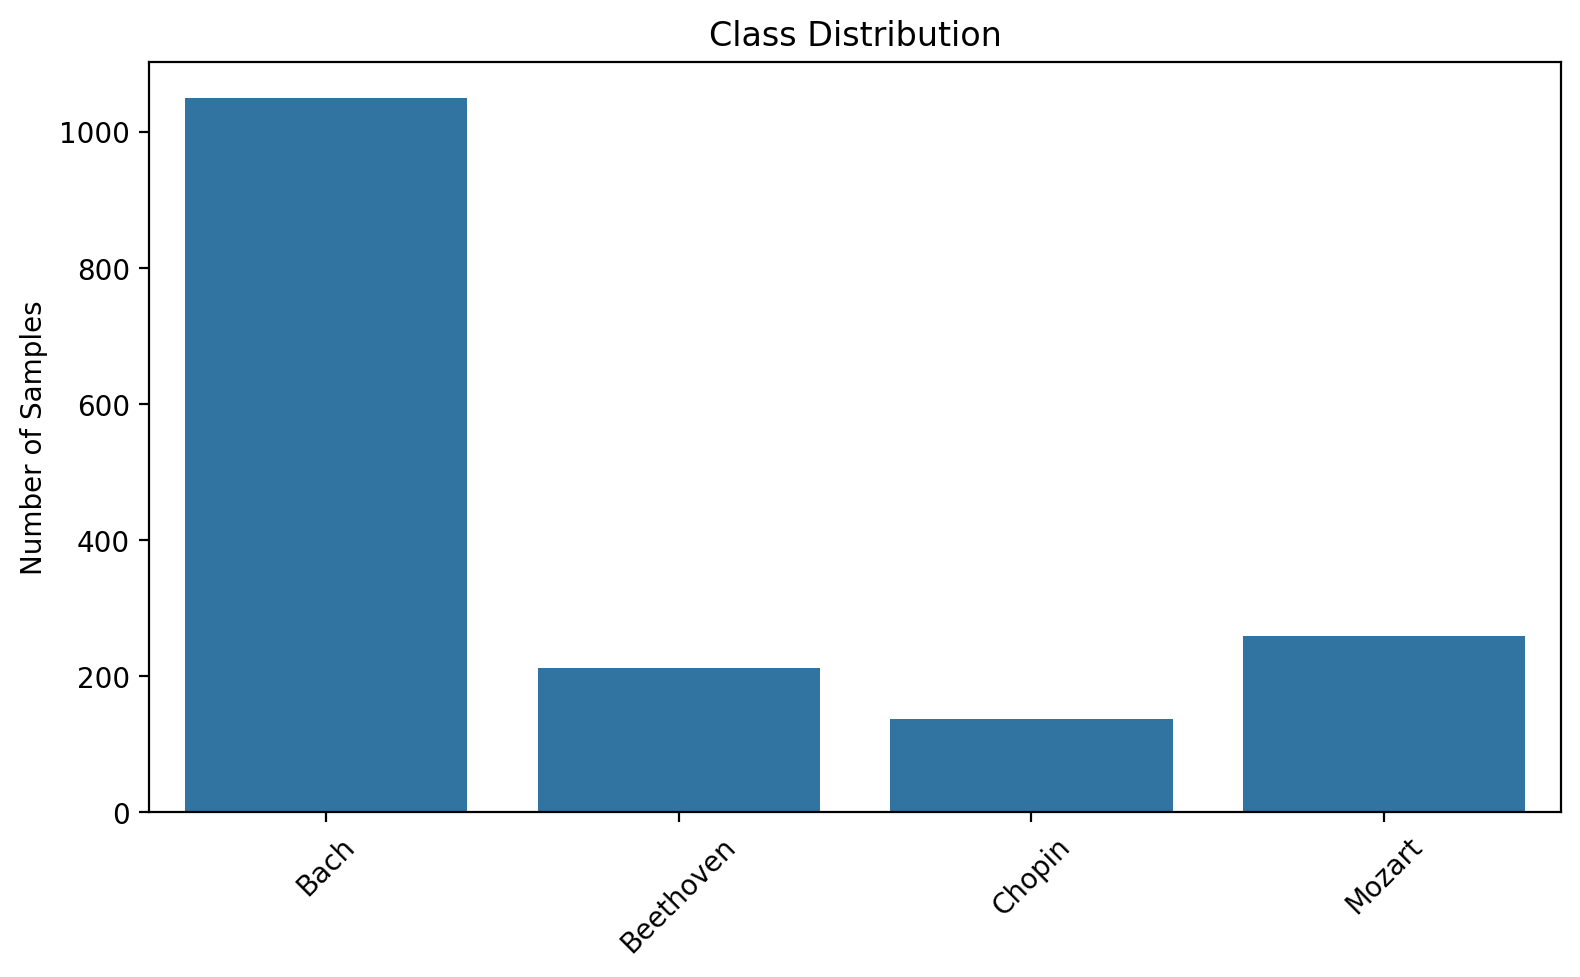

In [9]:
# Convert encoded labels back to composer names for readability
class_names = le.classes_
label_counts = pd.Series(y).value_counts().sort_index()

# Print counts
for idx, count in enumerate(label_counts):
    print(f"{class_names[idx]}: {count} samples")

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=class_names, y=label_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Compute class weights for the encoded labels
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

# Convert to dictionary format expected by Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

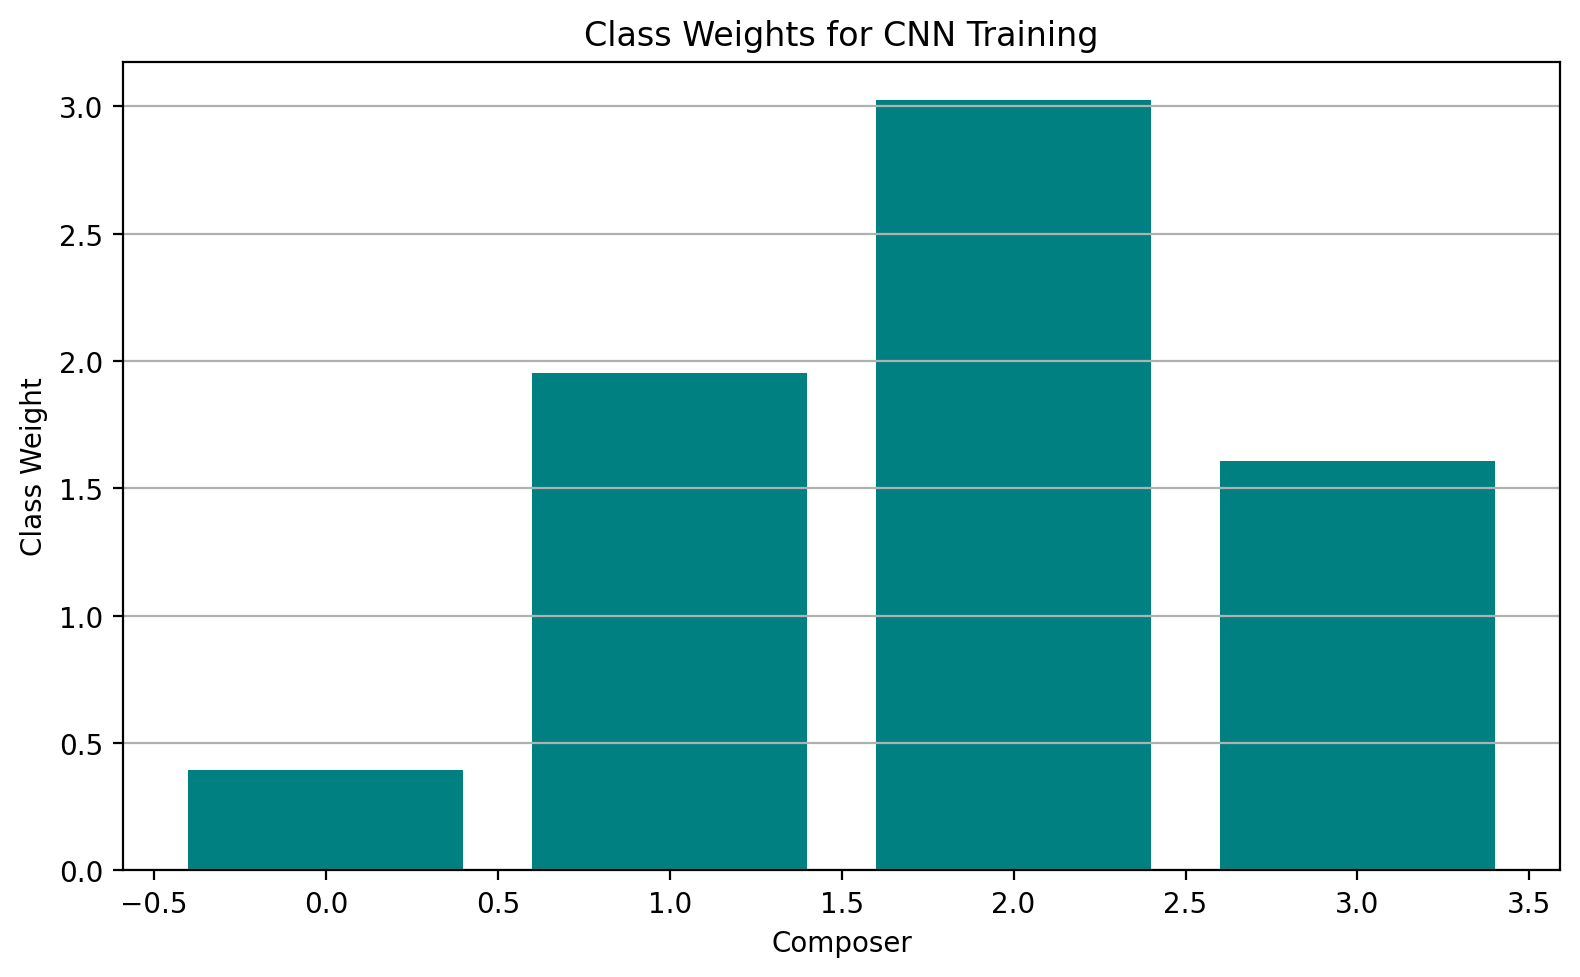

In [11]:
# Plot class weights
plt.figure(figsize=(8, 5))
plt.bar(class_weight_dict.keys(), class_weight_dict.values(), color='teal')
plt.title("Class Weights for CNN Training")
plt.xlabel("Composer")
plt.ylabel("Class Weight")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Num of classes: {num_classes}")


Shape of X: (1657, 256, 128, 2)
Shape of y: (1657,)
Num of classes: 4


In [ ]:
'''
# Reshape input to (samples, 256, 128, 1)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Build model
model_cnn = Sequential([
    Input(shape=(256, 128, 1)),

    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model_cnn.summary()
'''

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Build model with 2-channel input
model_cnn = Sequential([
    Input(shape=(256, 128, 2)),

    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 128, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 64, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 64, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,372 (399.89 KB)

 Trainable params: 101,924 (398.14 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model_cnn.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_cnn = model_cnn.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=30,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[early_stop])

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4935 - loss: 1.4862 - val_accuracy: 0.1265 - val_loss: 1.3902
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5346 - loss: 1.2298 - val_accuracy: 0.1566 - val_loss: 1.3077
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5739 - loss: 1.2215 - val_accuracy: 0.3253 - val_loss: 1.3376
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5852 - loss: 1.2149 - val_accuracy: 0.4819 - val_loss: 1.2838
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6166 - loss: 1.1239 - val_accuracy: 0.5542 - val_loss: 1.2291
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5765 - loss: 1.1965 - val_accuracy: 0.5964 - val_loss: 1.2156
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5822 - loss: 1.1867 - val_accuracy: 0.6084 - val_loss: 1.1967
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6288 - loss: 1.1402 - val_accuracy: 0.5964 - val_loss:

## CNN Model Evaluation

In [ ]:
# Evaluate the trained model
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.8149
Test Accuracy: 0.6747


In [24]:
# Plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [25]:
# Generate predictions and plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test, class_names):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

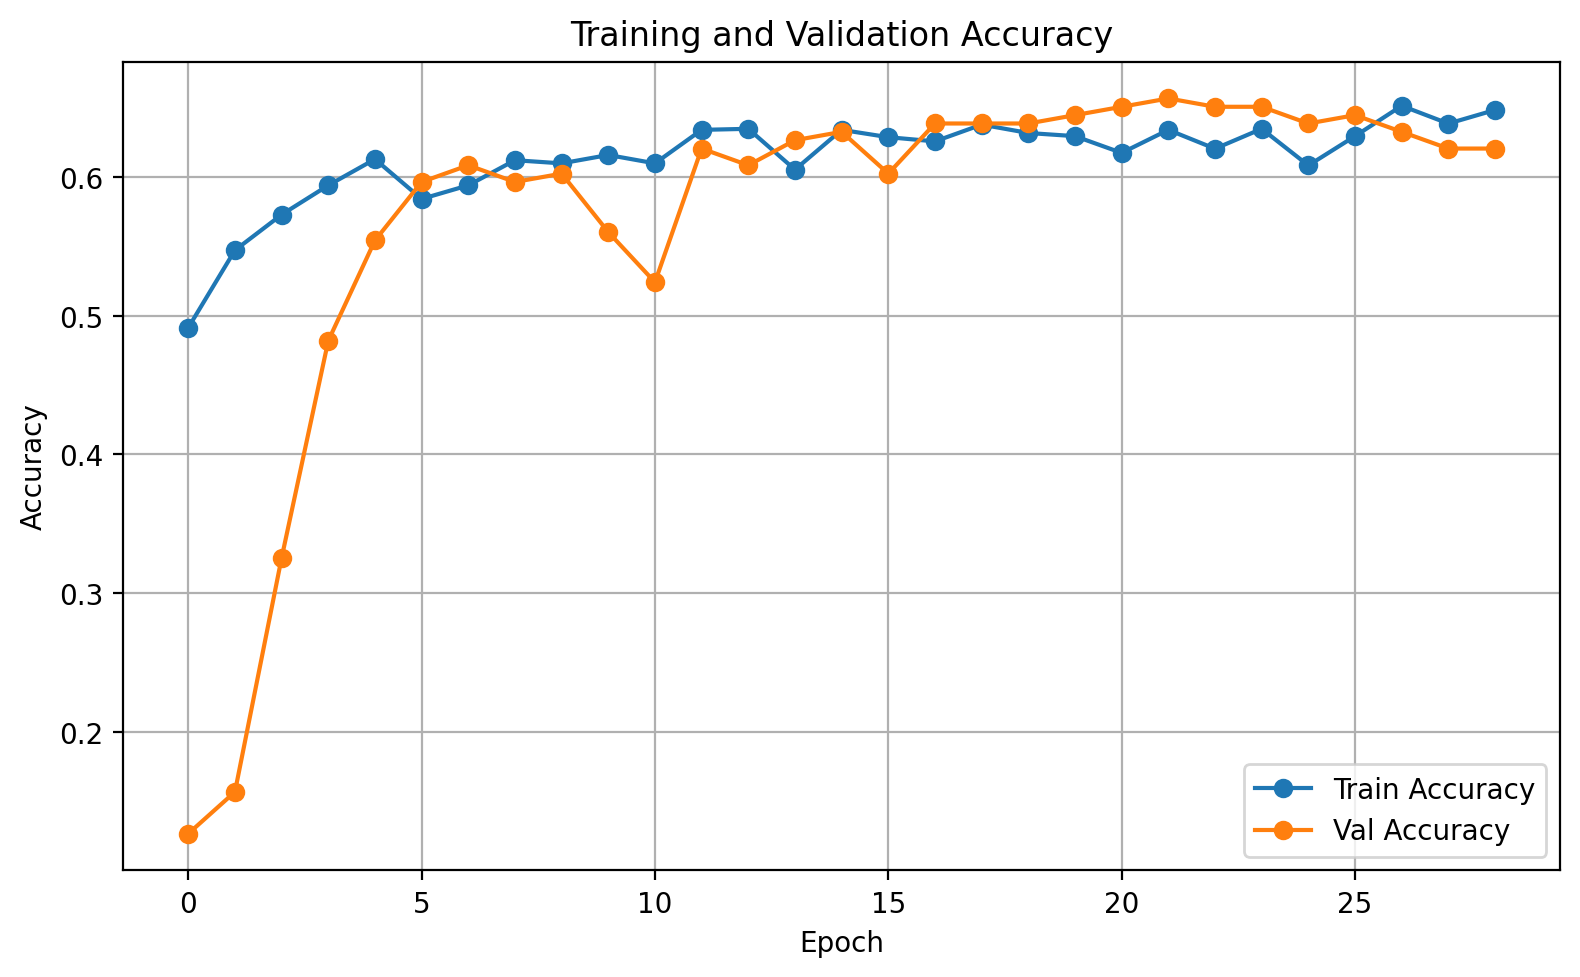

In [ ]:
# Plot accuracy
plot_accuracy(history_cnn)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


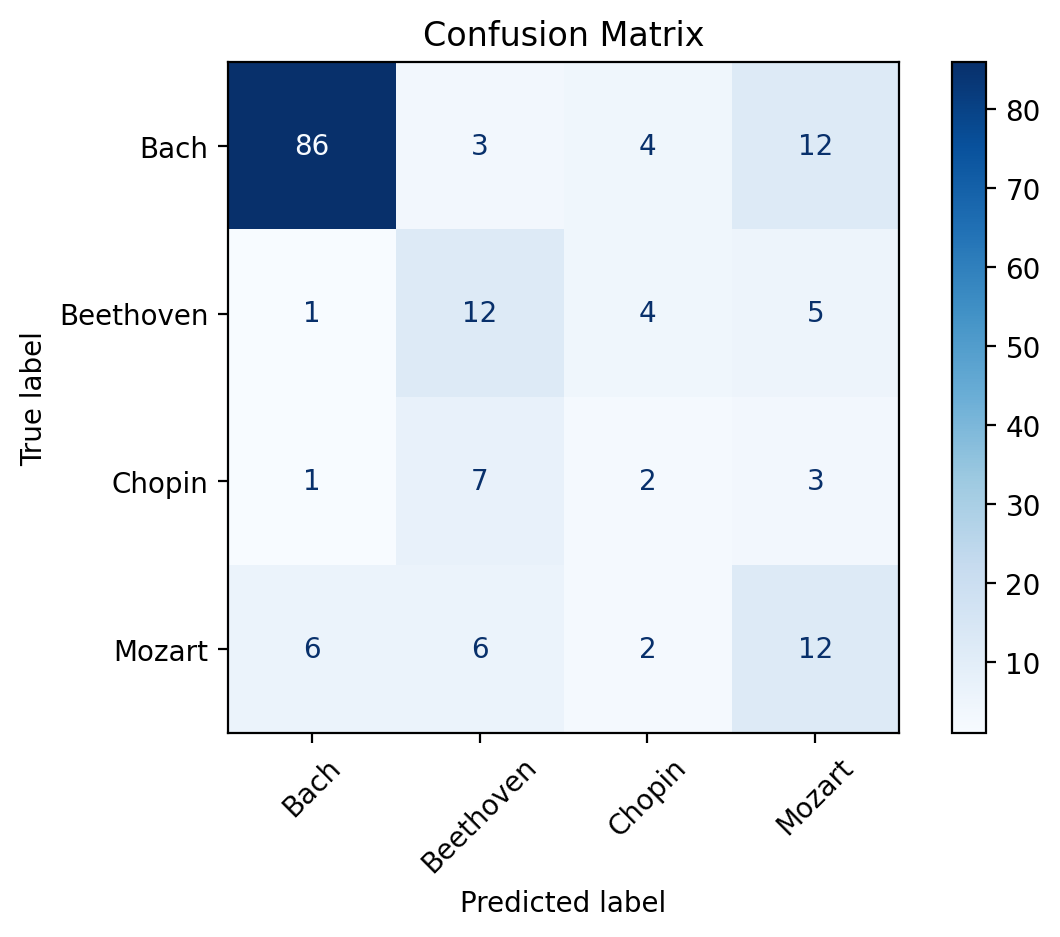

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model_cnn, X_test, y_test_cat, le.classes_)

In [12]:
'''
# Data augmentation for minority classes
def augment_mel_spectrogram(mel, mode='time_shift'):
    if mode == 'time_shift':
        shift = np.random.randint(-20, 20)
        return np.roll(mel, shift, axis=0)
    elif mode == 'pitch_shift':
        bins = np.random.randint(-5, 5)
        return np.roll(mel, bins, axis=1)
    elif mode == 'add_noise':
        noise = 0.01 * np.random.randn(*mel.shape)
        return mel + noise
    elif mode == 'time_mask':
        mel = mel.copy()
        t = np.random.randint(0, mel.shape[0] - 10)
        mel[t:t+10, :] = 0
        return mel
    elif mode == 'freq_mask':
        mel = mel.copy()
        f = np.random.randint(0, mel.shape[1] - 10)
        mel[:, f:f+10] = 0
        return mel
    else:
        return mel  # No augmentation
'''
# Data augmentation for minority classes
def augment_mel_spectrogram(mel, mode='time_shift'):
    mel = mel.copy()  # avoid modifying original
    augmented = np.empty_like(mel)

    for ch in range(mel.shape[-1]):
        channel = mel[:, :, ch]

        if mode == 'time_shift':
            shift = np.random.randint(-20, 20)
            augmented[:, :, ch] = np.roll(channel, shift, axis=0)

        elif mode == 'pitch_shift':
            bins = np.random.randint(-5, 5)
            augmented[:, :, ch] = np.roll(channel, bins, axis=1)

        elif mode == 'add_noise':
            noise = 0.01 * np.random.randn(*channel.shape)
            augmented[:, :, ch] = channel + noise

        elif mode == 'time_mask':
            t = np.random.randint(0, channel.shape[0] - 10)
            channel[t:t+10, :] = 0
            augmented[:, :, ch] = channel

        elif mode == 'freq_mask':
            f = np.random.randint(0, channel.shape[1] - 10)
            channel[:, f:f+10] = 0
            augmented[:, :, ch] = channel

        else:
            augmented[:, :, ch] = channel

    return augmented


In [13]:
'''
# Original dataset
X_aug, y_aug = list(X), list(y)
counts = Counter(y)

# Get target number (same as max class, e.g., Bach)
target_count = max(counts.values())

# For each class, augment until balanced
for cls in np.unique(y):
    cls_indices = [i for i, label in enumerate(y) if label == cls]
    while counts[cls] < target_count:
        idx = np.random.choice(cls_indices)
        mel = X[idx]
        mode = np.random.choice(['time_shift', 'pitch_shift', 'add_noise', 'time_mask', 'freq_mask'])
        mel_aug = augment_mel_spectrogram(mel, mode)
        X_aug.append(mel_aug)
        y_aug.append(cls)
        counts[cls] += 1
'''
from collections import Counter
import numpy as np

# Convert to lists for augmentation
X_aug, y_aug = list(X), list(y)

# Get current class counts
counts = Counter(y)
target_count = max(counts.values())

# Perform augmentation to balance classes
for cls in np.unique(y):
    cls_indices = [i for i, label in enumerate(y) if label == cls]
    print(f"Augmenting class {cls} from {counts[cls]} to {target_count}")

    while counts[cls] < target_count:
        idx = np.random.choice(cls_indices)
        mel = X[idx]
        mode = np.random.choice(['time_shift', 'pitch_shift', 'add_noise', 'time_mask', 'freq_mask'])

        try:
            mel_aug = augment_mel_spectrogram(mel, mode)
            X_aug.append(mel_aug)
            y_aug.append(cls)
            counts[cls] += 1
        except Exception as e:
            print(f"Augmentation failed for class {cls}: {e}")


Augmenting class 0 from 1050 to 1050
Augmenting class 1 from 212 to 1050
Augmenting class 2 from 137 to 1050
Augmenting class 3 from 258 to 1050


In [14]:
# Convert to numpy arrays
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

# One-hot encode y_aug
from keras.utils import to_categorical
y_aug_cat = to_categorical(y_aug, num_classes=num_classes)


In [15]:
# Split again into train/val/test, then retrain the model
# Train/validation/test split
X_aug_train, X_aug_temp, y_aug_train, y_aug_temp = train_test_split(X_aug, y_aug, test_size=0.2, stratify=y_aug, random_state=42)
X_aug_val, X_aug_test, y_aug_val, y_aug_test = train_test_split(X_aug_temp, y_aug_temp, test_size=0.5, stratify=y_aug_temp, random_state=42)

print(f"Shape of X: {X_aug.shape}")
print(f"Shape of y: {y_aug.shape}")
print(f"Num of classes: {num_classes}")

Shape of X: (4200, 256, 128, 2)
Shape of y: (4200,)
Num of classes: 4


In [16]:
# Reshape input to (samples, 256, 128, 1)
#X_aug_train_cnn = X_aug_train[..., np.newaxis]
#X_aug_val_cnn = X_aug_val[..., np.newaxis]
#X_aug_test_cnn = X_aug_test[..., np.newaxis]

y_aug_train_cat = to_categorical(y_aug_train, num_classes=num_classes)
y_aug_val_cat   = to_categorical(y_aug_val, num_classes=num_classes)
y_aug_test_cat  = to_categorical(y_aug_test, num_classes=num_classes)

In [17]:
print("X_aug_train:", X_aug_train.shape)          # (num_samples, 256, 128[, 1])
print("y_aug_train_cat:", y_aug_train_cat.shape)  # (num_samples, num_classes)
print("X_aug_val:", X_aug_val.shape)              # (num_val_samples, 256, 128[, 1])
print("y_aug_val_cat:", y_aug_val_cat.shape)      # (num_val_samples, num_classes)

X_aug_train: (3360, 256, 128, 2)
y_aug_train_cat: (3360, 4)
X_aug_val: (420, 256, 128, 2)
y_aug_val_cat: (420, 4)


In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_aug), y=y_aug)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
#X_aug_train = X_aug_train.reshape(-1, 256, 128, 1)
#X_aug_val = X_aug_val.reshape(-1, 256, 128, 1)
#X_aug_test = X_aug_test.reshape(-1, 256, 128, 1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_aug_cnn = model_cnn.fit(X_aug_train, y_aug_train_cat,
                    validation_data=(X_aug_val, y_aug_val_cat),
                    epochs=30,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[early_stop])

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.4531 - loss: 1.2928 - val_accuracy: 0.4286 - val_loss: 1.2277
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4976 - loss: 1.1094 - val_accuracy: 0.5143 - val_loss: 1.1237
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5429 - loss: 1.0535 - val_accuracy: 0.5381 - val_loss: 1.0843
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5342 - loss: 1.0683 - val_accuracy: 0.5262 - val_loss: 1.0770
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5453 - loss: 1.0176 - val_accuracy: 0.5452 - val_loss: 1.0624
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5714 - loss: 0.9862 - val_accuracy: 0.5500 - val_loss: 1.0794
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5456 - loss: 0.9993 - val_accuracy: 0.5262 - val_loss: 1.0758
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5797 - loss: 0.9665 - val_accu

In [ ]:

# Evaluate the trained model
test_loss, test_accuracy = model_cnn.evaluate(X_aug_test, y_aug_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.9083
Test Accuracy: 0.6333


## CNN Model Optimization

In [19]:
input_shape = (256, 128, 2)
num_classes = len(le.classes_)  # already computed

inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_opt_cnn = Model(inputs, outputs)
model_opt_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_opt_cnn.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 128, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 128, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 64, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 423,460 (1.62 MB)

 Trainable params: 422,500 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_opt_cnn = model_opt_cnn.fit(
    X_aug_train, y_aug_train_cat,
    validation_data=(X_aug_val, y_aug_val_cat),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.3452 - loss: 1.3494 - val_accuracy: 0.2500 - val_loss: 7.1643
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step - accuracy: 0.4687 - loss: 1.1348 - val_accuracy: 0.3476 - val_loss: 3.2749
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.5167 - loss: 1.0500 - val_accuracy: 0.5571 - val_loss: 1.0529
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.5293 - loss: 1.0052 - val_accuracy: 0.4190 - val_loss: 1.4540
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - accuracy: 0.5354 - loss: 1.0064 - val_accuracy: 0.4381 - val_loss: 1.3559
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.5740 - loss: 0.9429 - val_accuracy: 0.4071 - val_loss: 1.4759
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.5468 - loss: 0.9817 - val_accuracy: 0.4643 - val_loss: 1.2231
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 494s 5s/step - accuracy: 0.5918 - loss: 0.9312 - val_accu

In [22]:
# Evaluate the trained model
test_loss, test_accuracy = model_opt_cnn.evaluate(X_aug_test, y_aug_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.8090
Test Accuracy: 0.6310


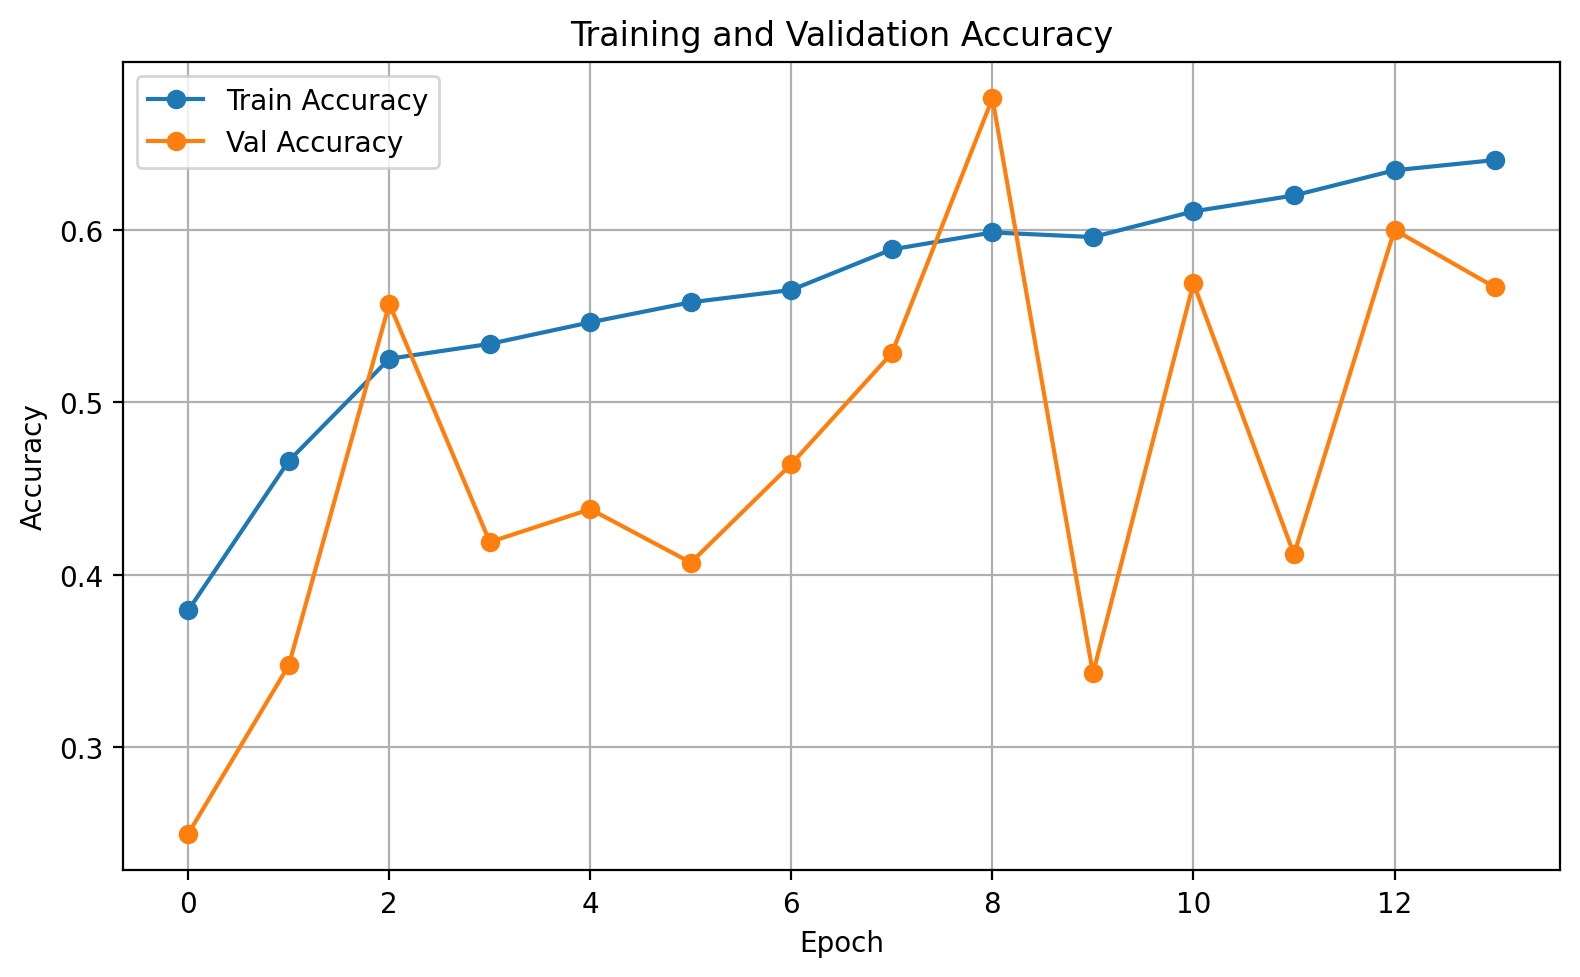

In [26]:
# Plot accuracy
plot_accuracy(history_opt_cnn)

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 932ms/step


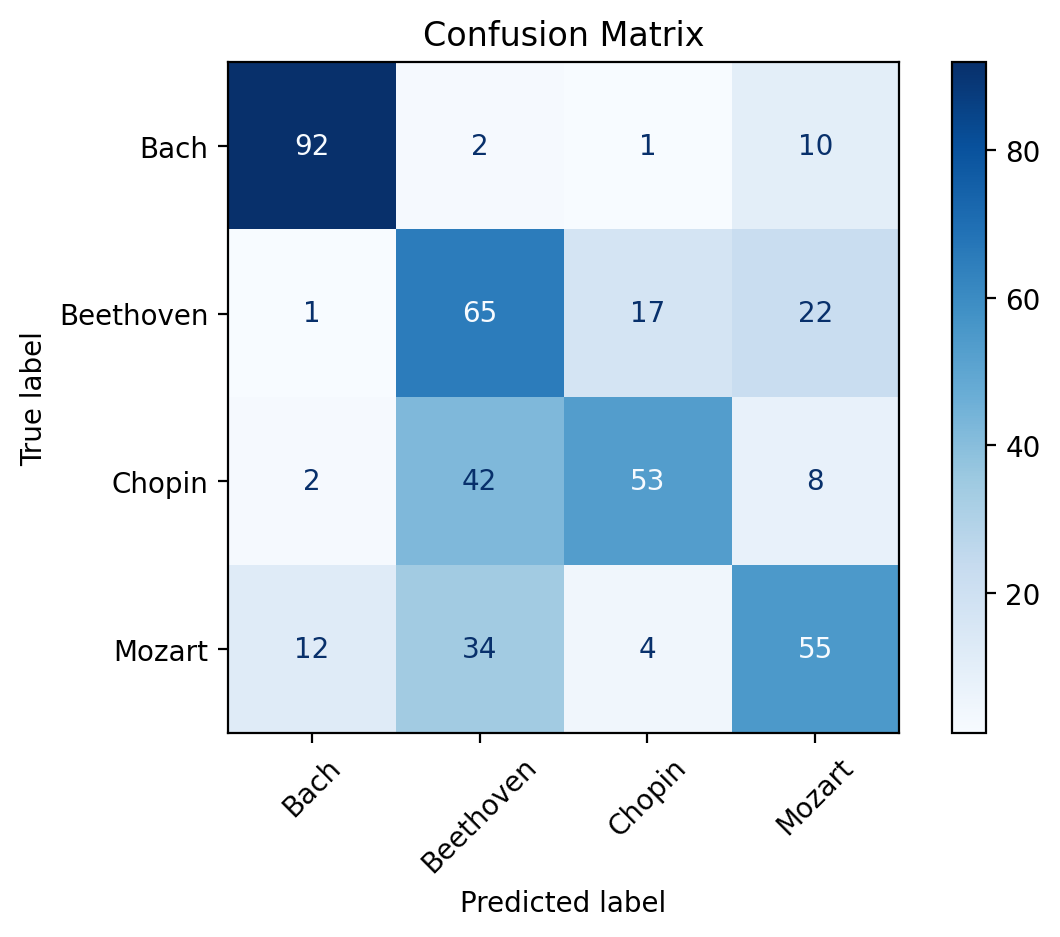

In [27]:
# Plot confusion matrix
plot_confusion_matrix(model_opt_cnn, X_aug_test, y_aug_test_cat, le.classes_)